# **Artificial Intelligence - Assignment 4 -  Practical Part**
### Mohammad Reza Nemati - 810100226
---
## **Machine Learning**
### Overview:
This machine learning project aims to predict house prices in Boston using various predictive models and techniques. The dataset used is the Boston Housing dataset, which contains information about different houses in Boston.

The project starts with data preprocessing, where any missing values are handled using imputation techniques. 

Next, the project explores different machine learning models. First we write the needed functions for Linear Regression and run it on all the features and plot the resutlts. Then KNN, Decision Trees and Random Forests were discussed in detail, with emphasis on how Random Forests can reduce variance through bootstrapping and averaging predictions from multiple trees. The concept of Gradient Boosting was also explained, which forms the basis for the XGBoost model, another model considered for this project.

Hyperparameter tuning is another crucial aspect of this project. The use of Grid Search was recommended due to the small and well-defined hyperparameter search space and the availability of sufficient computational resources.

The project aims to balance model accuracy with computational efficiency. It also emphasizes the importance of understanding the underlying algorithms and their assumptions. 


In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,  accuracy_score, classification_report
from seaborn import heatmap, diverging_palette
from scipy.stats import uniform
import seaborn as sns

## Dataset Overview

In [259]:
class Utils:
    @staticmethod
    def missing_report(df):
        nan_values = pd.DataFrame()
        nan_values['missing_count'] = df.isna().sum()
        nan_values['missing_percentage'] = nan_values['missing_count'] / df.shape[0] * 100

        return nan_values.round(4)
    
    @staticmethod
    def unique_report(df):
        uniques = df.nunique()
        
        plt.figure(figsize=(10, 6))
        uniques.plot(kind='bar')
        plt.title('Unique Items')
        plt.xlabel('Features')
        plt.ylabel('Frequency of Unique Items')
        plt.grid(axis='y', linestyle='-', alpha=0.7)
        plt.xticks(rotation=0)
        plt.show()
    
    @staticmethod
    def corr_heatmap(data):
        corr = data.corr()

        plt.figure(figsize=(20, 20))
        cmap = diverging_palette(220, 220, as_cmap=True)
        heatmap(corr, annot=True, fmt=".3f", cmap = 'RdBu', linewidths=1, square=True, center=0, vmax=1, vmin=-1)
        plt.show()

    @staticmethod
    def scatter_hexbin_plots(df, target):
        for col in df.columns:
            if col == target:
                continue
            fig, axs = plt.subplots(1, 2, figsize=(9, 3))
            axs[0].scatter(df[col], df[target])
            axs[0].set_xlabel(col)
            axs[0].set_ylabel(target)
            axs[0].set_title(f'Scatter Plot of {col} against {target}')
            axs[0].grid(True)
            hexb = axs[1].hexbin(df[col], df[target], gridsize=20, cmap='YlGnBu')
            axs[1].set_xlabel(col)
            axs[1].set_ylabel(target)
            axs[1].set_title(f'Hexbin Plot of {col} against {target}')
            axs[1].grid(True)
            plt.tight_layout()
            plt.colorbar(mappable=hexb)
            plt.show()

    @staticmethod
    def violin_plots(df):
        fig, axs = plt.subplots(7, 2, figsize=(20, 30))
        for i, column in enumerate(df.columns):
            sns.violinplot(data=df[column], ax=axs[int(i/2)][i%2])
            axs[int(i/2)][i%2].set_title(f'{column}')
            axs[int(i/2)][i%2].grid(visible=True, axis='y')
        plt.tight_layout()
        
        plt.show()

    @staticmethod
    def drop_unrelated_cols(df, target, threshold):
        target_corr = df.corr()[target].drop(target)
        target_corr = abs(target_corr)
        columns_to_drop = target_corr[target_corr < threshold].index

        return df.drop(columns_to_drop, axis=1)
    
    @staticmethod
    def get_train_test(X, Y, test_size):
        return train_test_split(X, Y, test_size=test_size, random_state=42)
    
    @staticmethod
    def get_designated_cols(df, target, threshold):
        target_corr = df.corr()[target].drop(target).sort_values(ascending=False)
        abs_target_corr = abs(target_corr).sort_values(ascending=False)
        return target_corr, abs_target_corr[abs_target_corr >= threshold].index.tolist()

### 1.1 Dataset Structure

In [260]:
df = pd.read_excel('DataSet.xlsx')
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222.0,18.7,NaN,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     480 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      479 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        486 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     452 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 55.5 KB


In [262]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,480.000000,506.000000,506.000000,506.000000,479.000000,506.000000,506.000000,506.000000,486.000000,506.000000,452.000000
mean,1.269195,13.295257,9.205158,0.175000,1.101175,15.679800,58.744660,6.211663,78.063241,339.317787,42.614980,336.820947,11.537806,23.750442
std,2.399207,23.048697,7.169630,0.380364,1.646991,27.220206,33.104049,6.527286,203.542157,180.670077,87.585243,121.174519,6.064932,8.808602
min,0.000000,0.000000,0.000000,0.000000,0.385000,3.561000,1.137000,1.129600,1.000000,20.200000,2.600000,0.320000,1.730000,6.300000
25%,0.049443,0.000000,3.440000,0.000000,0.449000,5.961500,32.000000,2.425900,4.000000,254.000000,17.000000,370.415000,6.877500,18.500000
50%,0.144655,0.000000,6.960000,0.000000,0.538000,6.322500,65.250000,3.917500,5.000000,307.000000,18.900000,390.885000,10.380000,21.950000
75%,0.819623,18.100000,18.100000,0.000000,0.647000,6.949000,89.975000,6.341400,24.000000,403.000000,20.200000,395.630000,15.015000,26.600000
max,9.966540,100.000000,27.740000,1.000000,7.313000,100.000000,100.000000,24.000000,666.000000,711.000000,396.900000,396.900000,34.410000,50.000000


#### 1.2 Missing Values

In [263]:
Utils.missing_report(df)

,missing_count,missing_percentage
CRIM,0,0.0000
ZN,0,0.0000
INDUS,0,0.0000
CHAS,26,5.1383
NOX,0,0.0000
RM,0,0.0000
AGE,0,0.0000
DIS,27,5.3360
RAD,0,0.0000
TAX,0,0.0000


#### 1.3 Unique Features

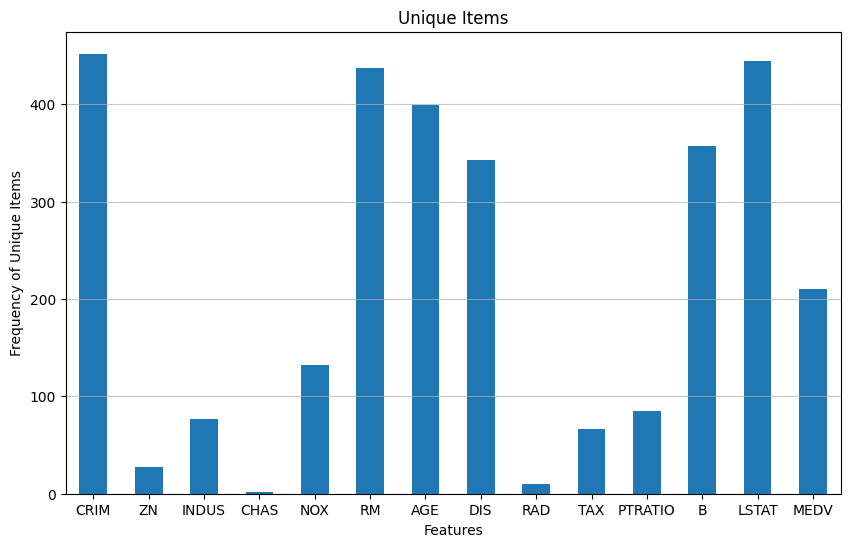

In [264]:
Utils.unique_report(df)

- In the plot above, it's evident that the number of unique items varies across columns. For instance, in columns such as CRIM (per capita crime rate by town) or LSTAT (% lower status of the population), the range of values is extensive, resulting in a high diversity of items. 

- Conversely, in columns like CHAS (Charles River dummy variable), which only takes values of 0 or 1, the variability is minimal. 

- Additionally, for columns like RAD (index of accessibility to radial highways), although the range of values is not small, the majority of data points have low values for this attribute (with 75% of the data having RAD values lower than 24), leading to a reduced variety in this column.

#### 1.4 Correlations

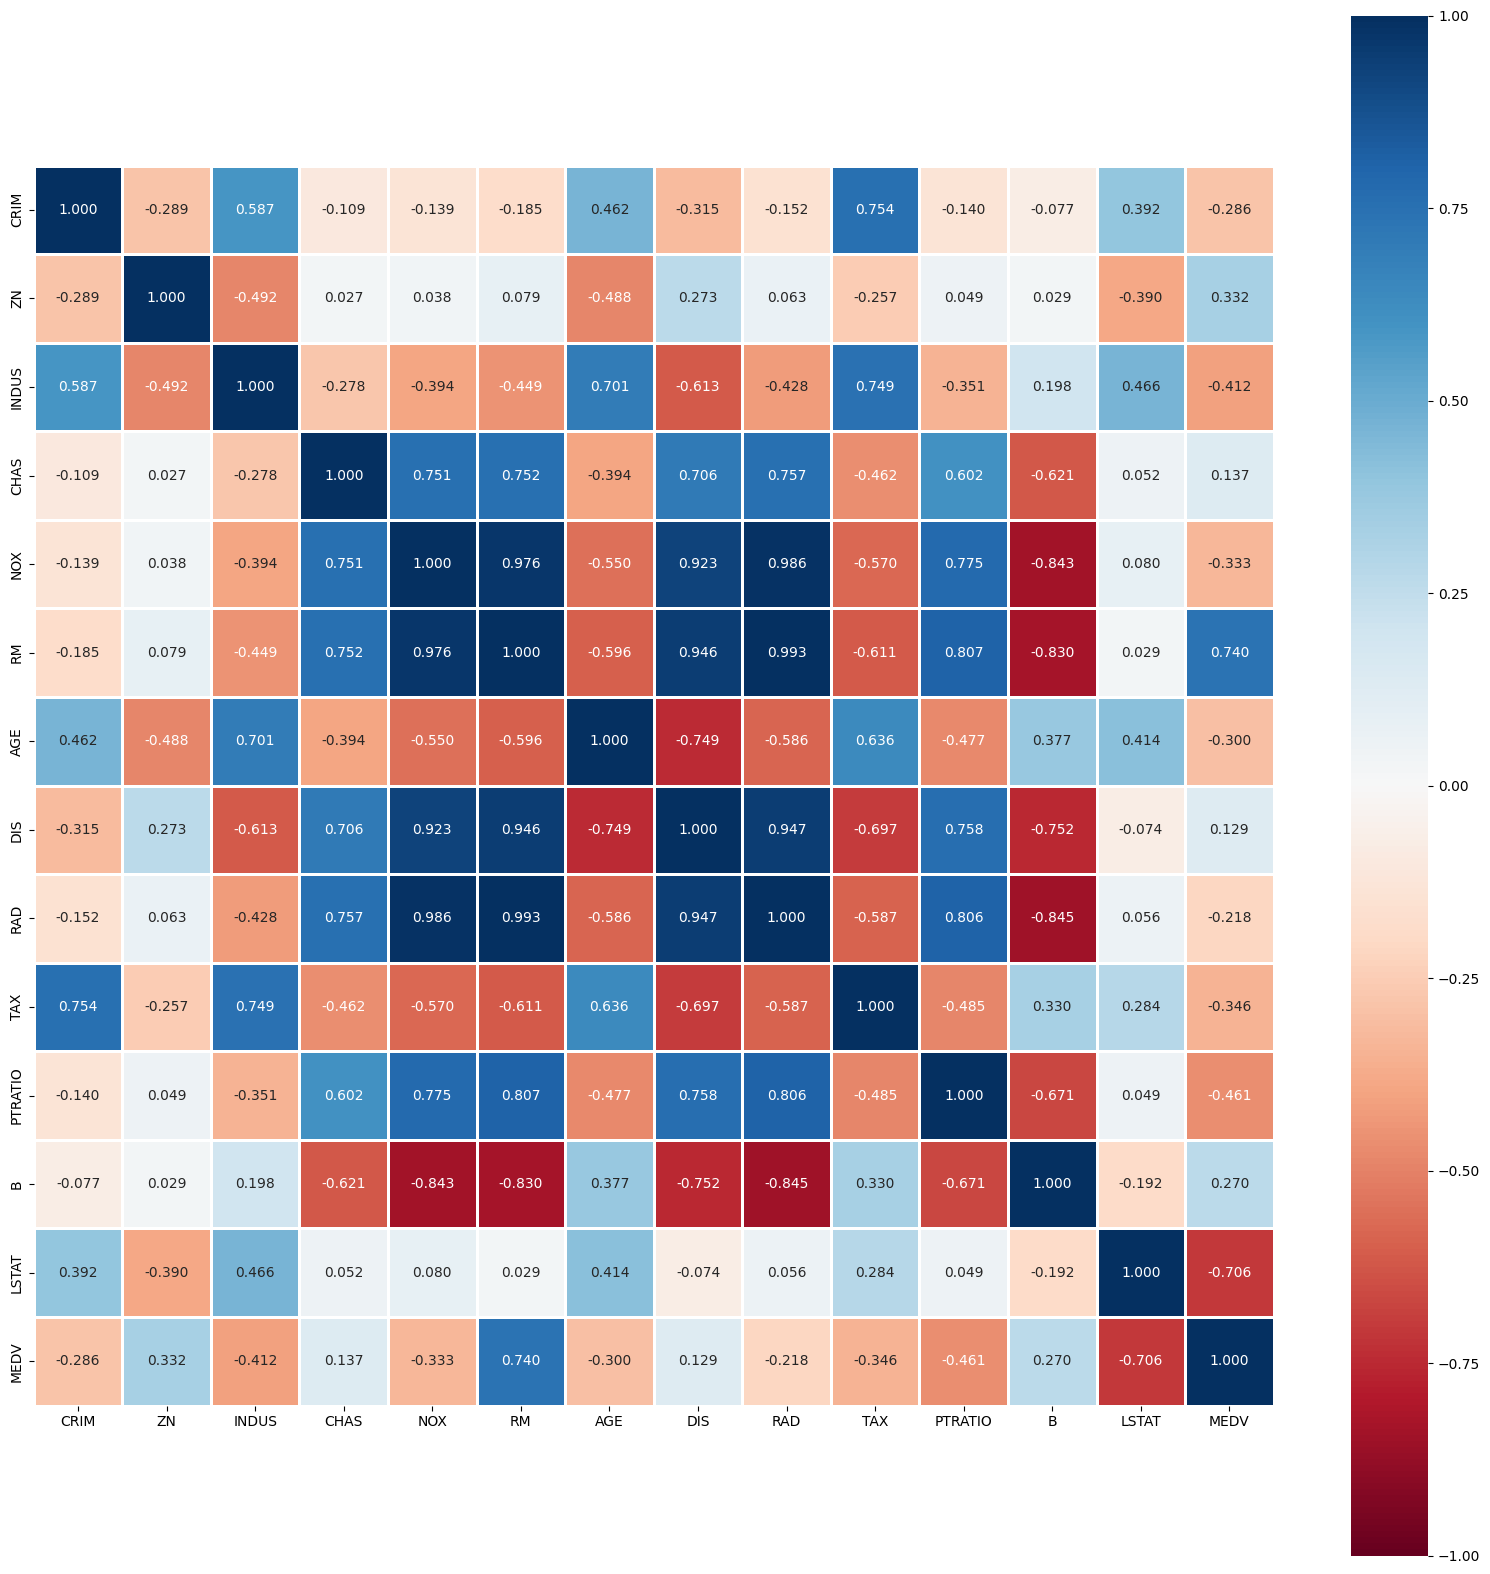

In [265]:
Utils.corr_heatmap(df)

The Correlation Matrix shows the correlation of each two features with each other, positive correlation is shown with blue colors and as we move to red colors, more negative the correlation gets.

We set the projec's target `MEDV` (Median value of owner-occupied homes in $1000s). 

- Features with positive correlation with the target are `RM`, `ZN`, ... and features with negative correlation with it are `LSTAT`, `PTRATIO`.

- Features like `DIS` and `RAD` have high positive correlation with features like `CHAS`, `NOX` and `RM`. This means that they're related and when one of them is high, the other one is probably high as well. On the other hand `CHAS`, `NOX` and `RM` have high negative correlation with `B`, which means when `CHAS`, `NOX` and `RM` have a high value, `B` probably has a low value.

- Features like `CHAS`, `NOX` and `RM` have near zero correlation with `ZN` which means they're not related.

#### 1.5 Scatter and Hexbin Plots

- **Scatter plot**

    - A scatter plot is a type of graph used to display the relationship between two continuous variables. Each point on the graph represents an individual data point with its position determined by the values of these two variables.
    
    - Scatter plots are particularly useful for identifying trends, patterns, and potential correlations between variables. They can also help detect outliers or unusual observations within the data set.

- **Hexbin plot**

    - A Hexbin plot is a graphical representation that organizes data into hexagonal bins for visualization. It’s particularly effective when dealing with large datasets as it helps to avoid overplotting.

    - Hexbin plots are a powerful tool in data visualization for revealing underlying patterns in complex and voluminous data.

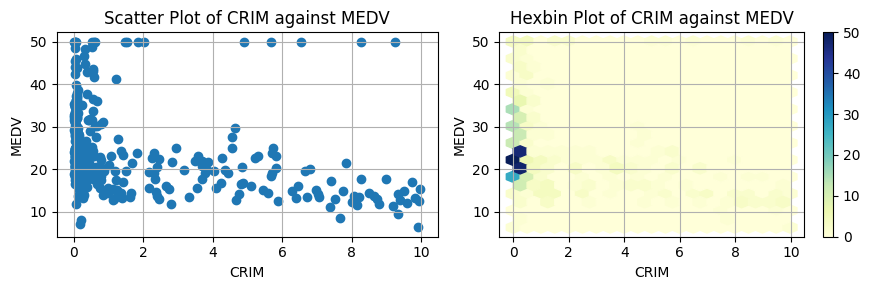

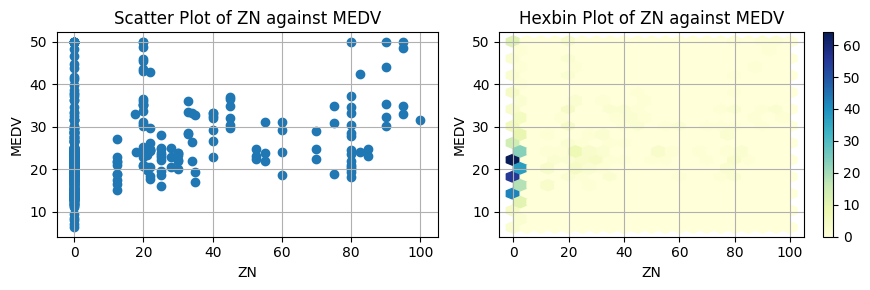

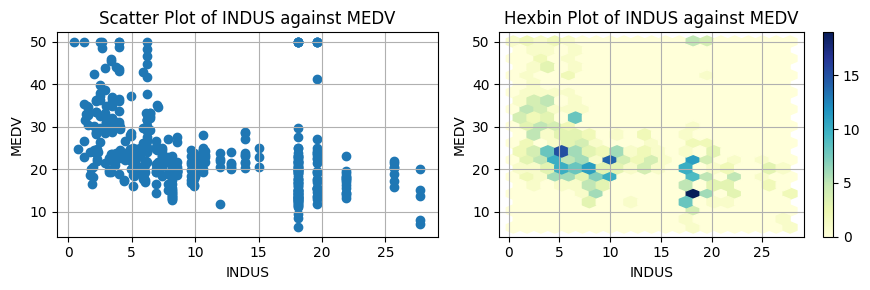

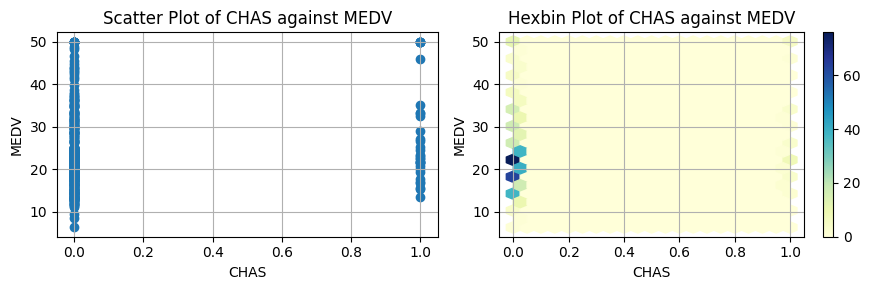

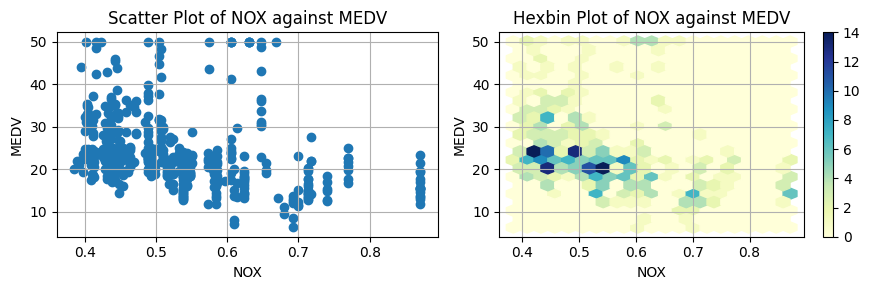

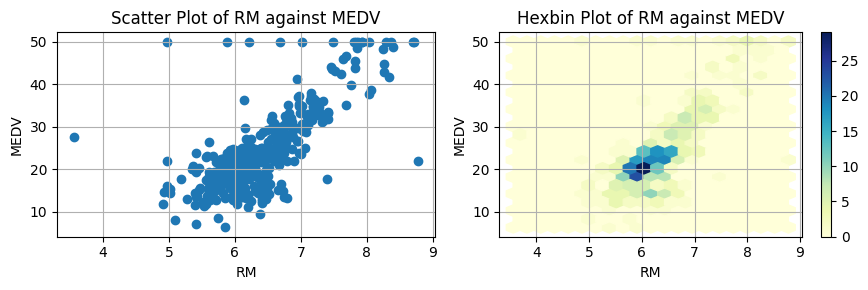

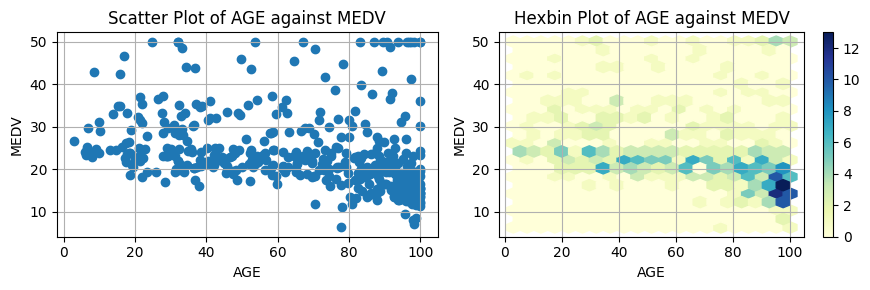

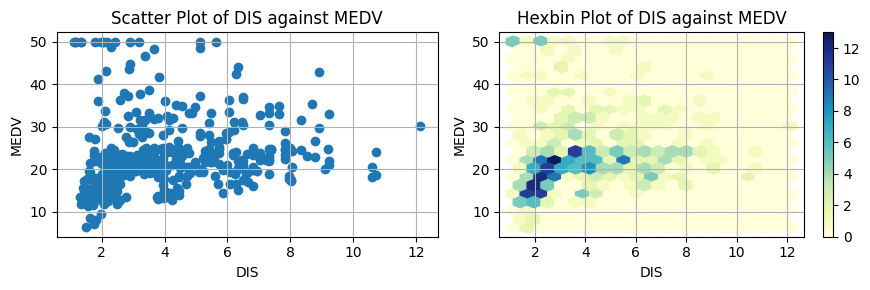

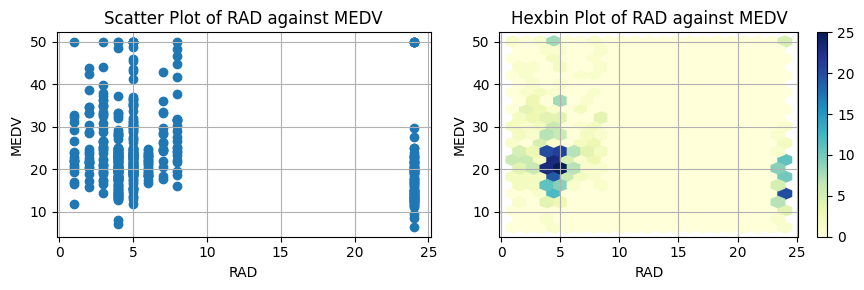

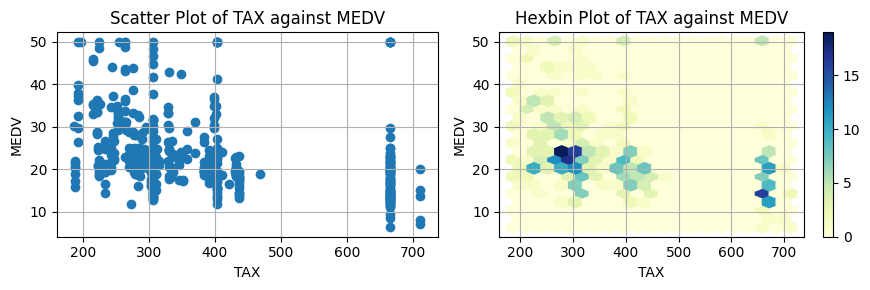

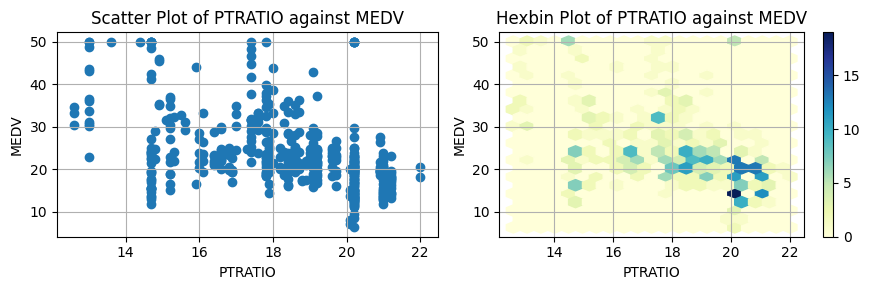

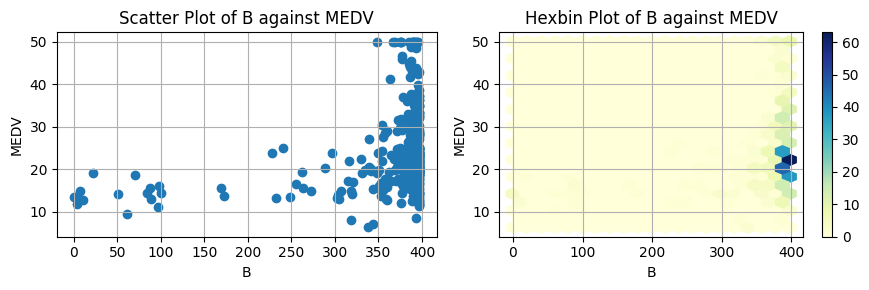

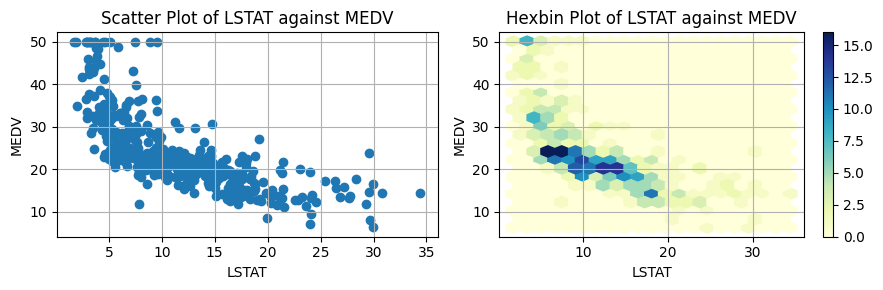

In [266]:
Utils.scatter_hexbin_plots(df, 'MEDV')

#### 1.6 Others

- **box plot**

    - A box plot is a graphical method for summarizing the distribution of a continuous variable through its quartiles. The box in the plot represents the interquartile range (IQR), which encompasses the middle 50% of the data. The line inside the box represents the median (50th percentile) of the data.

    - A box plot displays a summary of the range and distribution of data values in a sample. It provides a visual summary that enables us to easily compare between groups.
    
    - Box plots are useful for identifying outliers and for comparing distributions. However, they do not show the shape of the distribution, and it is possible for different shaped distributions to have the same box plot.

- **violin plot**
    - A violin plot is a method of plotting numeric data and is similar to a box plot, with the addition of a rotated kernel density plot on each side.
    
    - Violin plots are more informative than plain box plots. A box plot only shows summary statistics such as mean/median and interquartile ranges, but the violin plot shows the full distribution of the data. The difference in the shape of the density plot provides an insight into the distribution shape of the data.

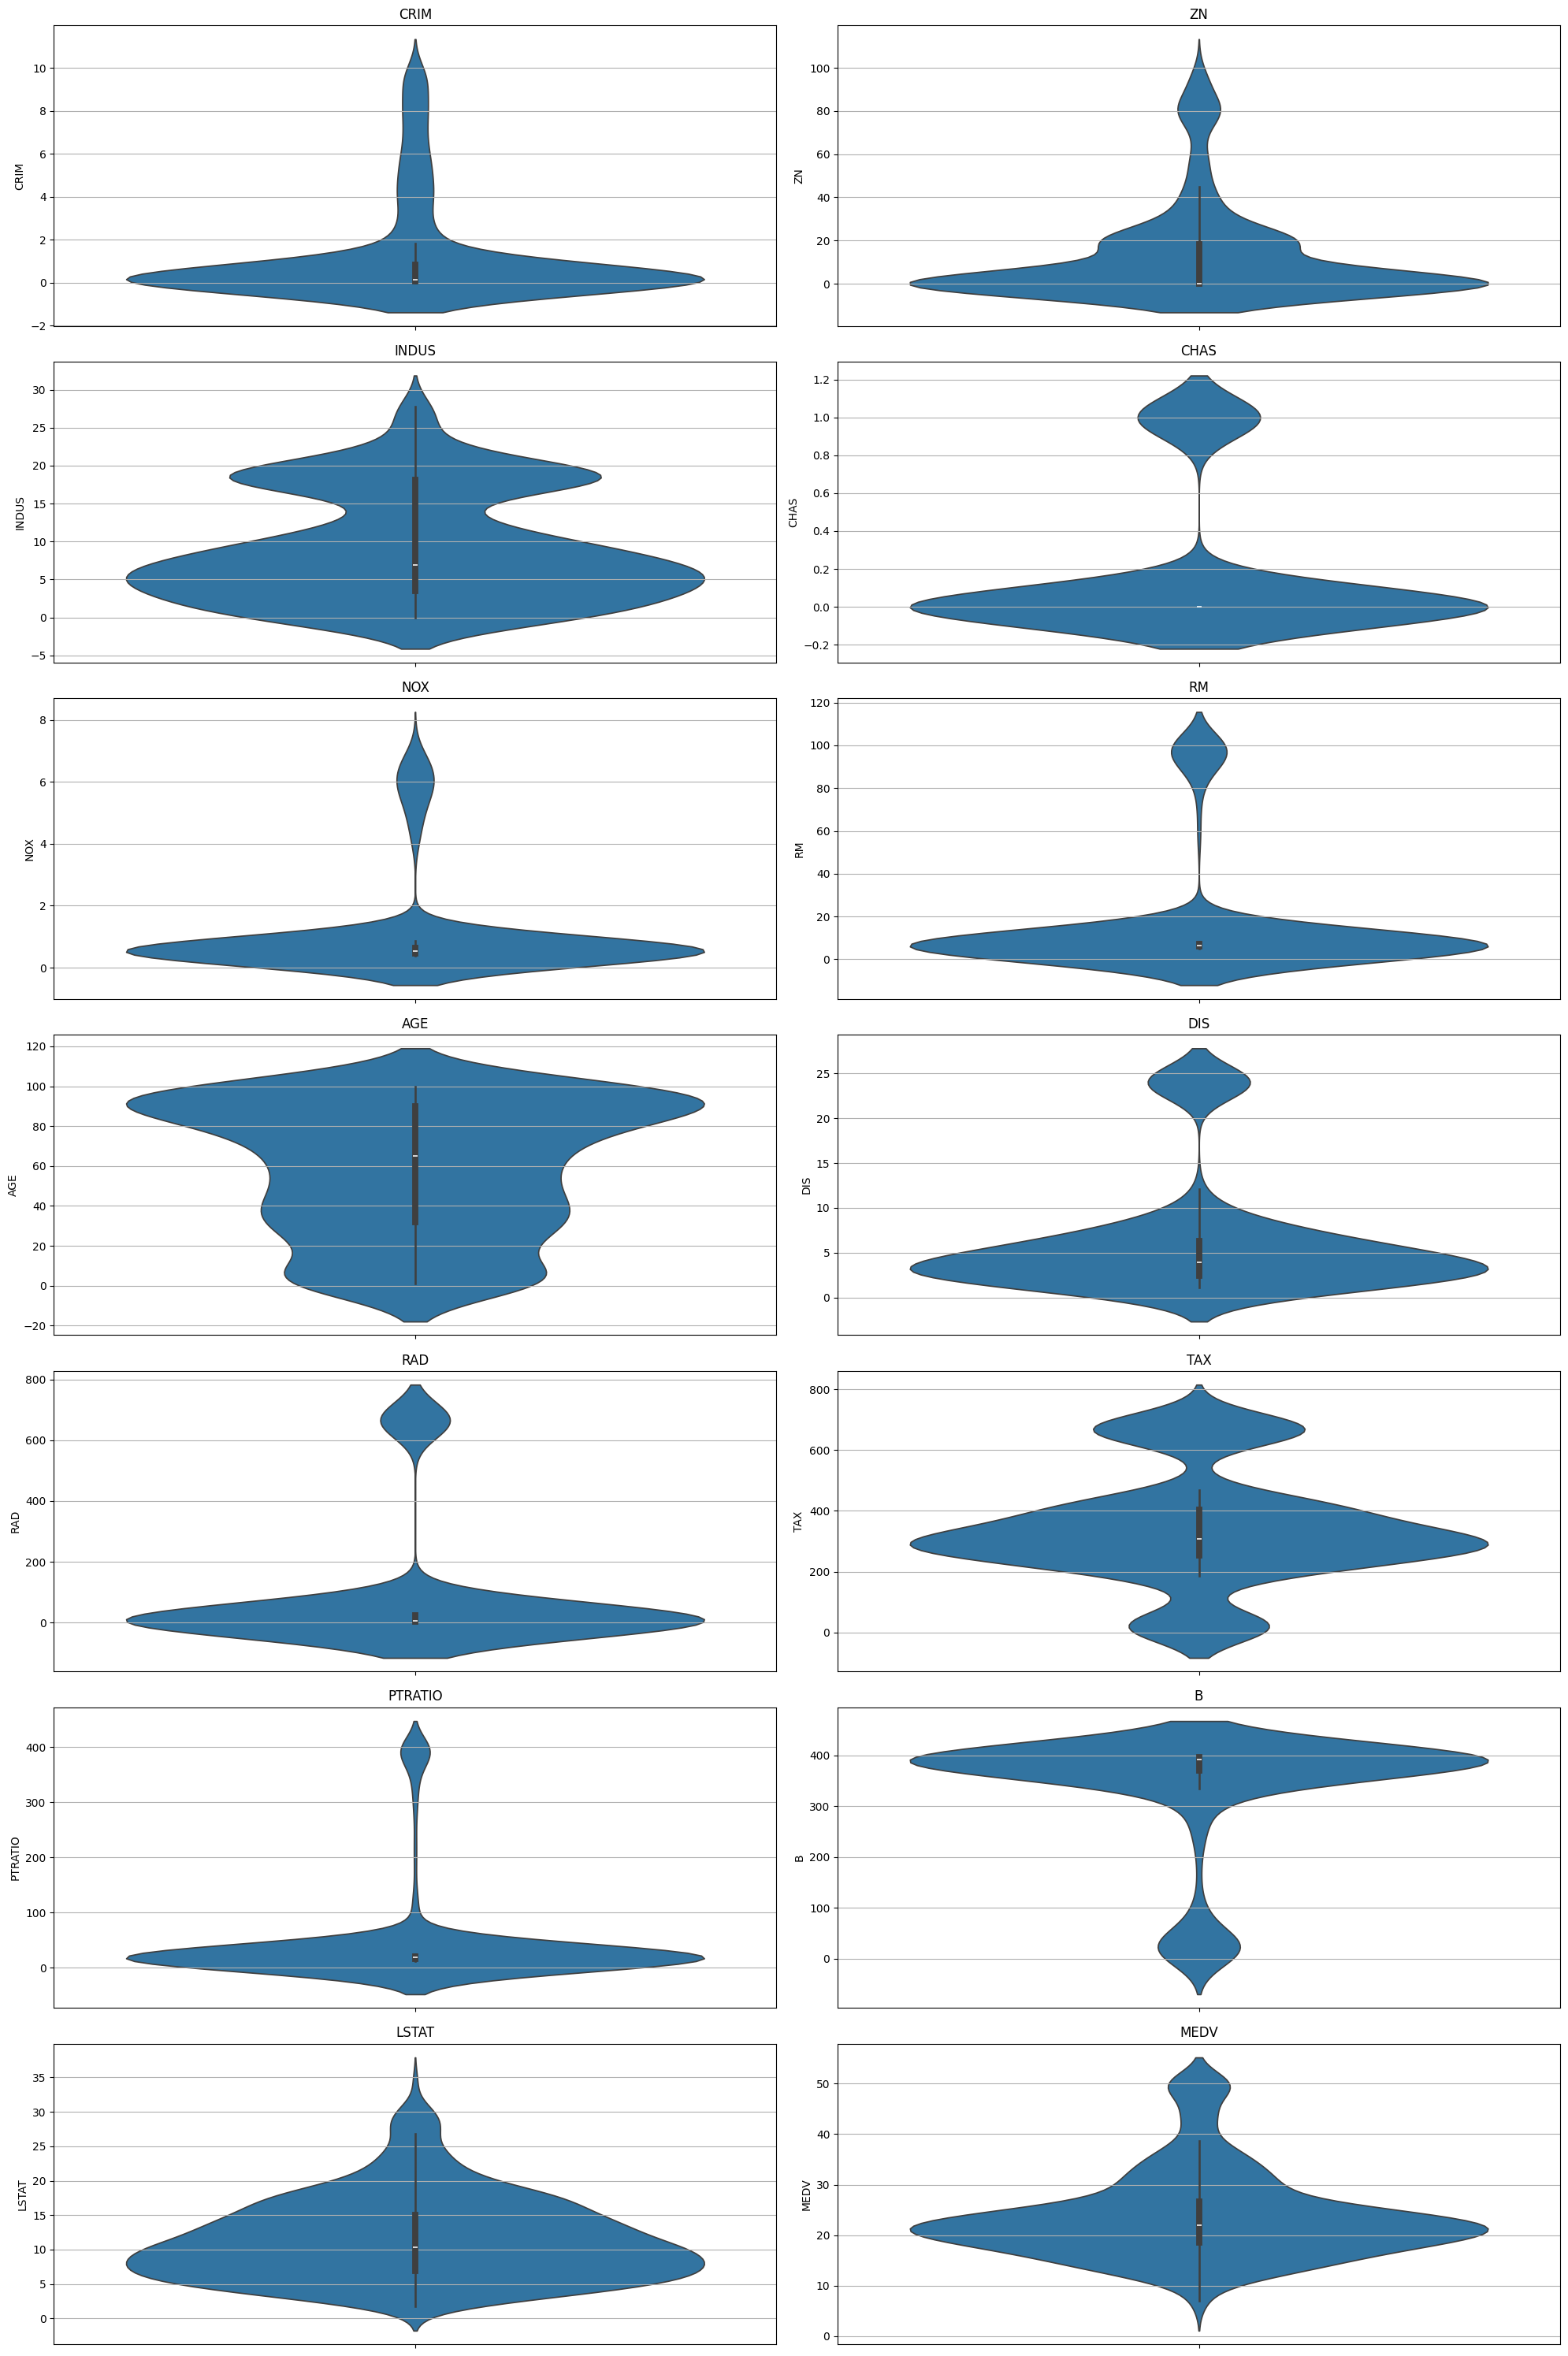

In [267]:
Utils.violin_plots(df)

## Dataset Preprocessing

### 7. Handling Missing Values

There are several methods to handle missing values:

- `Deletion`: In this approach, rows or columns with missing values are removed from the dataset.

- `Mean/median imputation`: In this approach, you calculate the mean or median of the available values for a particular feature and use that value to fill in the missing values. It's a simple method that works well for numerical data.

- `Random imputation`: Random imputation fills missing values by randomly selecting values from the observed data in the same column. It's useful when missing data is randomly distributed. However, it may introduce noise and potentially affect correlations with other variables, including the target variable. Therefore, its impact on correlation should be carefully considered, especially in cases where missing data might not be completely random.

- `Linear interpolation`: Linear interpolation is a straightforward method for estimating missing values in a dataset by assuming a linear relationship between neighboring data points. In linear interpolation, the missing value is estimated based on the values of adjacent known data points.

- `Mode imputation`: For categorical or discrete data, you can use the mode (most frequent value) to fill in missing values. It's similar to mean/median imputation but applied to categorical variables.

- `Forward fill`: This method involves propagating the last observed value forward to fill in missing values. It's useful when dealing with time series or sequential data.

- `Backward fill`: This method is the opposite of forward fill. It propagates the next observed value backward to fill in missing values. It's also applicable to time series or sequential data.

- `Regression imputation`: Regression-based imputation involves using regression models to predict missing values based on other variables in the dataset. You can train a regression model using the available data and use it to predict missing values.


#### 7.1 Deletion

In [268]:
df_dropped = df.dropna()
df_dropped.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000,391.000000
mean,1.466072,12.626598,10.150281,0.066496,0.540974,6.327090,65.691560,4.077932,7.877238,376.933504,18.309719,370.042685,11.406675,23.516113
std,2.583902,24.067772,6.569721,0.249467,0.113629,0.623912,28.368892,2.133013,7.612087,148.503115,2.184093,70.435329,5.969739,8.371697
min,0.006320,0.000000,0.460000,0.000000,0.389000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,6.300000
25%,0.071580,0.000000,4.930000,0.000000,0.447000,5.936000,40.800000,2.354300,4.000000,277.000000,16.900000,378.365000,6.665000,18.500000
50%,0.188360,0.000000,8.140000,0.000000,0.520000,6.229000,72.700000,3.495200,5.000000,311.000000,18.600000,392.400000,10.260000,22.000000
75%,1.172330,20.000000,18.100000,0.000000,0.605000,6.617000,91.600000,5.471300,7.000000,407.000000,20.200000,396.660000,15.025000,25.750000
max,9.966540,100.000000,27.740000,1.000000,0.871000,8.704000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.410000,50.000000


#### 7.2 Median

In [269]:
df_filled = df.fillna(df.median())
df_filled.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,1.269195,13.295257,9.205158,0.166008,1.101175,15.679800,58.744660,6.089248,78.063241,339.317787,42.614980,338.957866,11.537806,23.558300
std,2.399207,23.048697,7.169630,0.372456,1.646991,27.220206,33.104049,6.371337,203.542157,180.670077,87.585243,119.218004,6.064932,8.342912
min,0.000000,0.000000,0.000000,0.000000,0.385000,3.561000,1.137000,1.129600,1.000000,20.200000,2.600000,0.320000,1.730000,6.300000
25%,0.049443,0.000000,3.440000,0.000000,0.449000,5.961500,32.000000,2.471800,4.000000,254.000000,17.000000,372.182500,6.877500,19.000000
50%,0.144655,0.000000,6.960000,0.000000,0.538000,6.322500,65.250000,3.917500,5.000000,307.000000,18.900000,390.885000,10.380000,21.950000
75%,0.819623,18.100000,18.100000,0.000000,0.647000,6.949000,89.975000,6.256850,24.000000,403.000000,20.200000,395.597500,15.015000,25.000000
max,9.966540,100.000000,27.740000,1.000000,7.313000,100.000000,100.000000,24.000000,666.000000,711.000000,396.900000,396.900000,34.410000,50.000000


#### 7.3 Random imputation

In [270]:
random_impute_df = df.copy()
df_no_missing = df.dropna()

missing_rows = df[df.isnull().any(axis=1)]

for i in missing_rows.index:
    random_row = df_no_missing.sample(1)
    random_impute_df.loc[i] = random_row.values

df = random_impute_df
random_impute_df.describe(include='all')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.00000,506.000000,506.000000,506.000000,506.000000
mean,1.408712,13.832016,9.720949,0.059289,0.536128,6.352211,64.832016,4.121746,7.628458,372.23913,18.196245,369.773794,11.240573,23.783202
std,2.567301,25.162884,6.456470,0.236398,0.109963,0.627207,28.117717,2.080689,7.459216,145.47128,2.207737,72.373868,5.999130,8.422404
min,0.006320,0.000000,0.460000,0.000000,0.389000,3.561000,2.900000,1.129600,1.000000,187.00000,12.600000,0.320000,1.730000,6.300000
25%,0.068600,0.000000,4.490000,0.000000,0.447000,5.954000,38.925000,2.421000,4.000000,277.00000,16.800000,381.600000,6.657500,18.700000
50%,0.173885,0.000000,7.870000,0.000000,0.516500,6.247000,70.400000,3.633800,5.000000,307.00000,18.600000,392.800000,10.130000,22.200000
75%,0.849165,20.000000,18.100000,0.000000,0.585000,6.619000,90.625000,5.499950,6.000000,403.00000,20.200000,396.390000,14.800000,26.600000
max,9.966540,100.000000,27.740000,1.000000,0.871000,8.704000,100.000000,12.126500,24.000000,711.00000,22.000000,396.900000,34.410000,50.000000


In [271]:
Utils.missing_report(df)

,missing_count,missing_percentage
CRIM,0,0.0
ZN,0,0.0
INDUS,0,0.0
CHAS,0,0.0
NOX,0,0.0
RM,0,0.0
AGE,0,0.0
DIS,0,0.0
RAD,0,0.0
TAX,0,0.0


### 8. Dropping Non-Important Columns

To detect non-important features related to the target, we set a threshold of 0.2 so that the columns that have a positive correlation less than 0.2 or negative correlation more than -0.2 with the target are considered non-important and are removed.


In [273]:
df = Utils.drop_unrelated_cols(df, 'MEDV', threshold=0.2)
df

,CRIM,ZN,INDUS,NOX,RM,AGE,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.538,6.575,65.2,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.9,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.469,7.185,61.1,2,242.0,17.8,392.83,4.03,34.7
3,0.17142,0.0,6.91,0.448,5.682,33.8,3,233.0,17.9,396.90,10.21,19.3
4,0.06905,0.0,2.18,0.458,7.147,54.2,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.573,6.593,69.1,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.573,6.120,76.7,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.573,6.976,91.0,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.573,6.794,89.3,1,273.0,21.0,393.45,6.48,22.0


### 9. Numeric and Categorical Values

- **Categorical Values** are variables that can take on a limited, fixed number of values, representing qualitative data. Examples include gender, color, or type of car. These values are often represented by labels or categories.

- **Numeric Values**, are variables that represent quantitative data and can take on numerical values. Examples include age, height, or temperature. Numeric values can be further categorized into two types:

    1. **Discrete Numeric Values**: These are numeric values that are finite and countable, typically representing whole numbers. Examples include the number of children in a family or the number of items sold.

    2. **Continuous Numeric Values**: These are numeric values that can take on any value within a certain range. Examples include weight, temperature, or time.

In this project `CHAS` column is the only categorical feature and the rest of the features are numerical.

### 10. Normalizing and Standardizing

Normalizing and standardizing are techniques used in data preprocessing to scale numeric features to a similar range. 

- **Normalization**:
    - Normalization scales the values of a feature to a range between 0 and 1.
    - It's useful when the distribution of the feature doesn't follow a Gaussian distribution (normal distribution).

- **Standardization**:
    - Standardization scales the values of a feature to have a mean of 0 and a standard deviation of 1.
    - It's useful when the distribution of the feature approximates a Gaussian distribution.

- **Differences**:
    - Range: Normalization scales values to a range between 0 and 1, while standardization centers the data around 0 with a standard deviation of 1.
    - Sensitivity to outliers: Normalization can be sensitive to outliers, especially when the range is large, while standardization is more robust to outliers because it's based on the mean and standard deviation.
    - Interpretation: Normalization maintains the relative relationships between values but may not preserve the original distribution, while standardization preserves the distribution but may not maintain relative relationships.

Normalizing in this project is not necessary since the outputs won't be different.

### 11. Categorical Features Preprocess

There are some useful preprocessing techniques for categorical features:

1. **One-Hot Encoding**:
   - Convert each categorical value into a binary vector where each category becomes a binary feature.
   - Useful when the categories have no inherent ordinal relationship.

2. **Label Encoding**:
   - Convert each categorical value into a numerical label.
   - Useful when the categories have an inherent ordinal relationship.

3. **Ordinal Encoding**:
   - Similar to label encoding, but the numerical labels are assigned based on the ordinal relationship between the categories.
   - Useful when the categories have a clear order.

4. **Frequency Encoding**:
   - Replace categorical values with the frequency of each category in the dataset.
   - Useful when the frequency of occurrence of each category is relevant information.


5. **Target Encoding (Mean Encoding)**:
   - Replace categorical values with the mean of the target variable for each category.
   - Useful for classification tasks when the target variable is categorical.

### 12. Train, Test and Validation

Train, test, and validation data are essential components in machine learning model development for evaluating performance, tuning parameters, and preventing overfitting.

1. **Training Data**:
   - Training data is used to train the machine learning model.
   - It consists of input features and their corresponding target labels (in supervised learning).
   - The model learns patterns and relationships within the training data to make predictions.

2. **Test Data**:
   - Test data is used to evaluate the performance of the trained model.
   - It is not used during the training process and represents unseen data to assess how well the model generalizes to new examples.
   - Test data also consists of input features and their corresponding target labels.

3. **Validation Data**:
   - Validation data is an additional dataset used to tune hyperparameters and assess model performance during training.
   - It helps prevent overfitting by providing an independent dataset for evaluating model performance during training.
   - Validation data is particularly useful when fine-tuning model parameters or selecting between different models.

The usual practice for dividing data into these three sets involves the following steps:

1. **Initial Splitting**:
   - The original dataset is split into two parts: training data and test data.
   - The training data typically comprises a larger portion of the dataset, often around 70-80%, while the test data comprises the remaining portion (20-30%).
   - This initial split ensures that there is a separate dataset available for evaluating the trained model's performance.

2. **Validation Splitting**:
   - Optionally, the training data can be further divided into training and validation sets.
   - The training set is used to train the model, while the validation set is used to assess the model's performance during training and tune hyperparameters.
   - The validation set helps prevent overfitting by providing an independent dataset for evaluating model performance.


In [274]:
X = df.drop(columns=['MEDV'])
Y = df['MEDV']

X_train, X_test, y_train, y_test = Utils.get_train_test(X, Y, test_size=0.2)
X_train, X_val, y_train, y_val = Utils.get_train_test(X_train, y_train, test_size=0.25)

### 13. Other Methods of Preprocessing

- **Feature Engineering**:
    - Feature engineering involves creating new features or transforming existing features to improve model performance. This can include techniques like binning, polynomial features, interaction terms, or extracting relevant information from existing features.

- **Dimensionality Reduction**:

    - Dimensionality reduction techniques like Principal Component Analysis (PCA) or t-distributed Stochastic Neighbor Embedding (t-SNE) can be used to reduce the number of features while retaining most of the variance in the data, thus speeding up training and reducing overfitting.

- **Data Augmentation**:

    - In tasks like image classification, data augmentation techniques like rotation, flipping, scaling, or adding noise to images can be used to artificially increase the size of the training dataset and improve model generalization.

- **Handling Imbalanced Classes**:

    In classification tasks with imbalanced class distributions, techniques like oversampling (increasing the number of minority class samples), undersampling (reducing the number of majority class samples), or using algorithms like SMOTE (Synthetic Minority Over-sampling Technique) can be employed to balance the class distribution.

# Linear Regression

### 14. Different Methods of Learning

1. **Supervised Learning**:
   - Supervised learning involves training a model on a labeled dataset, where each input example is associated with a corresponding target label.
   - The goal is to learn a mapping from inputs to outputs based on the labeled examples provided during training.
   - Example: Email spam classification, where the model learns to classify emails as either spam or not spam based on features extracted from the email content and labeled examples indicating whether each email is spam or not.

2. **Unsupervised Learning**:
   - Unsupervised learning involves training a model on an unlabeled dataset, where the model learns to find patterns, structures, or representations in the data without explicit guidance.
   - The goal is to uncover hidden patterns or groupings within the data.
   - Example: Clustering similar documents together in a large corpus of text documents based on their content similarities, without any prior labels indicating document categories.

3. **Semi-supervised Learning**:
   - Semi-supervised learning is a hybrid approach that combines labeled and unlabeled data for training.
   - The model leverages both labeled and unlabeled examples to learn better representations or improve performance on tasks with limited labeled data.
   - Example: Image classification with a large dataset of images where only a small portion is labeled. By using the labeled data along with the unlabeled data, the model can improve its accuracy in classifying images into various categories.

4. **Reinforcement Learning**:
   - Reinforcement learning involves training an agent to interact with an environment to achieve a specific goal by taking actions that maximize cumulative rewards.
   - The agent learns through trial and error by receiving feedback from the environment in the form of rewards or penalties.
   - Example: Training an autonomous robot to navigate through a maze to reach a target destination. The robot learns to take actions (e.g., moving forward, turning left or right) based on its current state and receives rewards (e.g., positive reward for reaching the destination, negative reward for hitting obstacles) to optimize its pathfinding behavior over time.


### 15. Regression vs. Classification

1. **Regression**:
   - Regression is a supervised learning task where the goal is to predict a continuous numerical value.
   - It is typically used when the target variable (the variable being predicted) is a real-valued quantity, such as price, temperature, or stock price.
   - The output of a regression model is a continuous value that represents the predicted quantity.
   - Example: Predicting house prices based on features like size, number of bedrooms, and location. Here, the target variable (house price) is a continuous value, and the model predicts a specific price for each house.

2. **Classification**:
   - Classification is a supervised learning task where the goal is to predict which category or class an input belongs to.
   - It is used when the target variable is categorical, meaning it takes on discrete values or classes.
   - The output of a classification model is a class label that represents the predicted category.
   - Example: Classifying emails as either spam or not spam based on features extracted from the email content. Here, the target variable (spam or not spam) is categorical, and the model predicts the category to which each email belongs.

Main form of simple linear regression function:
$$f(x) = \alpha x + \beta$$

here we want to find the bias ($\alpha$) and slope($\beta$) by minimizing the derivation of the Residual Sum of Squares (RSS) function:

- step 1: Compute RSS of the training data  

$$ RSS = \Sigma (y_i - (\hat{\beta} + \hat{\alpha} * x_i) )^2 $$

- step 2: Compute the derivatives of the RSS function in terms of $\alpha$ and $\beta$, and set them equal to 0 to find the desired parameters

$$ \frac{\partial RSS}{\partial \beta} = \Sigma (-f(x_i) + \hat{\beta} + \hat{\alpha} * x_i) = 0$$
$$ \to \beta = \hat{y} - \hat{\alpha} \hat{x} \to (1)$$


$$ \frac{\partial RSS}{\partial \alpha} = \Sigma (-2 x_i y_i + 2 \hat{\beta} x_i + 2\hat{\alpha} x_i ^ 2) = 0 \to (2)$$

$$ (1) , (2) \to \hat{\alpha} = \frac{\Sigma{(x_i - \hat{x})(y_i - \hat{y})}}{\Sigma{(x_i - \hat{x})^2}}
$$
$$ \hat{\beta} = y - \hat{a} x$$



### 16. Linear Regression Formula Overview

RSS calculates the squared distance of each true point ($y_i$) in the dataset with the predicted point using the linear regression model ($\alpha x_i + \beta$).
This cost function (RSS) is to be minimized, so its derivative is calculated in terms of the variables ($\alpha$ and $\beta$) and set to zero. The optimal $\alpha$ and $\beta$ are calculated in this manner.

Based on the above formula, implement the function below to compute the parameters of a simple linear regression

In [275]:
def linear_regression(input, output):
    mean_x = np.mean(input)
    mean_y = np.mean(output)
    alpha = np.sum((input - mean_x) * (output - mean_y)) / np.sum(np.power(input - mean_x, 2))
    beta = mean_y - alpha * mean_x
    return alpha, beta

Now complete this `get_regression_predictions(...)` function to predict the value of given data based on the calculated intercept and slope

In [276]:
def get_regression_predictions(input, intercept, slope):
    return intercept * input + slope

### 17. Select Feature

The linear regression model takes only one feature as input. The method chosen in this project for choosing that feature is picking the feature with highest correlation with the target. 

By selecting the feature with the highest correlation, we're aiming to maximize the predictive power of the model. Features with higher correlation are expected to have a stronger influence on the target variable. 

However, linear regression assumes a linear relationship between the input features and the target variable. If the true relationship is non-linear, selecting features based solely on correlation might not capture the full complexity of the relationship.



In [277]:
df.corr()['MEDV'].drop('MEDV').sort_values(ascending=False)

RM         0.736123
ZN         0.377698
B          0.269967
RAD       -0.251367
CRIM      -0.318835
AGE       -0.318990
NOX       -0.325824
TAX       -0.348499
INDUS     -0.415856
PTRATIO   -0.481046
LSTAT     -0.685309
Name: MEDV, dtype: float64

So `RM` can be good choice for linear regression.

### 18. Regression Models Evaluation

1. **Residual Sum of Squares (RSS)**:
   - RSS is a measure of the discrepancy between the observed values and the values predicted by the regression model.
   - It is calculated as the sum of the squared differences between the actual target values and the predicted values.

2. **Mean Squared Error (MSE)**:
   - MSE is the average of the squared differences between the actual and predicted values.
   - It is calculated by dividing the RSS by the number of observations.
   - MSE gives a measure of the average squared deviation between predicted and actual values.

3. **Root Mean Squared Error (RMSE)**:
   - RMSE is the square root of the MSE and is expressed in the same units as the target variable.
   - It is more interpretable than the MSE.

4. **Coefficient of Determination (\(R^2\) Score)**:
   - \(R^2\) score measures the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features) in the model.
   - It is a value between 0 and 1, where 1 indicates a perfect fit and 0 indicates no linear relationship between the variables.


These metrics are widely used to assess the goodness-of-fit of regression models and compare different models' performance. Lower values of MSE and RMSE indicate better model performance, while higher values of \(R^2\) indicate a better fit of the model to the data.

### .

Now that we have a model and can make predictions, let's evaluate our model using Root Mean Square Error (RMSE). RMSE is the square root of the mean of the squared differences between the residuals, and the residuals is just a fancy word for the difference between the predicted output and the true output.

Complete the following function to compute the RSME of a simple linear regression model given the input_feature, output, intercept and slope:

In [278]:
def get_root_mean_square_error(predicted_values, actual_values):
  mean_square = np.mean(np.power(predicted_values - actual_values, 2))
  return np.sqrt(mean_square)

The RMSE has no bound, thus it becomes challenging to determine whether a particular RMSE value is considered good or bad without any reference point. Instead, we use R2 score. The R2 score is calculated by comparing the sum of the squared differences between the actual and predicted values of the dependent variable to the total sum of squared differences between the actual and mean values of the dependent variable. The R2 score is formulated as below:

$$R^2 = 1 - \frac{SSres}{SStot} = 1 - \frac{\sum_{i=1}^{n} (y_{i,true} - y_{i,pred})^2}{\sum_{i=1}^{n} (y_{i,true} - \bar{y}_{true})^2} $$

Complete the following function to calculate the R2 score of a given input_feature, output, bias, and slope:

In [279]:
def get_r2_score(predicted_values, actual_values):
    SS_res = np.sum(np.power(predicted_values - actual_values, 2))
    SS_tot = np.sum(np.power(actual_values - actual_values.mean(), 2))
    return 1 - SS_res / SS_tot

Now calculate the fitness of the model.
Remember to provide explanation for the outputs in your code!

In [280]:
def run_linear_regression(df, feature, ax, corr):
    bias, slope = linear_regression(X_train[feature], y_train)
    predicted_values = get_regression_predictions(X_test[feature], bias, slope)
    rmse = get_root_mean_square_error(predicted_values, y_test)
    r2_score = get_r2_score(predicted_values, y_test)

    print(f"{feature}:")
    print(f"\tCorrelation: {corr:0.4f}")
    print(f"\tRMSE: {rmse:0.4f}")
    print(f"\tR2-Score: {r2_score:0.4f}")
    print(f"\ty = {bias:0.4f} * x + {slope:0.4f}")
    print("------------------------")

    x_line = np.linspace(min(df[feature]), max(df[feature]), 100)
    y_line = bias * x_line + slope

    ax.scatter(X_train[feature], y_train)
    ax.plot(x_line, y_line, color='red', label = f"y = {bias:0.4f} * x + {slope:0.4f}")
    ax.plot(x_line, x_line, color='purple', linestyle='--',  label = f"y = x")
    ax.set_ylabel('MEDV')
    ax.set_xlabel(feature)
    ax.set_title(feature)
    ax.legend()

### 19 and 20. Features Evaluation With Linear Regression Scorings

We run the tests for all features.

RM:
	Correlation: 0.7361
	RMSE: 6.1708
	R2-Score: 0.4701
	y = 10.7815 * x + -44.7454
------------------------
LSTAT:
	Correlation: -0.6853
	RMSE: 6.5356
	R2-Score: 0.4055
	y = -1.0010 * x + 35.0697
------------------------
PTRATIO:
	Correlation: -0.4810
	RMSE: 7.1590
	R2-Score: 0.2867
	y = -1.7226 * x + 55.2262
------------------------
INDUS:
	Correlation: -0.4159
	RMSE: 7.7511
	R2-Score: 0.1638
	y = -0.5125 * x + 29.0935
------------------------
ZN:
	Correlation: 0.3777
	RMSE: 7.3503
	R2-Score: 0.2481
	y = 0.1170 * x + 22.5483
------------------------
TAX:
	Correlation: -0.3485
	RMSE: 7.9908
	R2-Score: 0.1113
	y = -0.0206 * x + 31.6714
------------------------
NOX:
	Correlation: -0.3258
	RMSE: 8.0966
	R2-Score: 0.0877
	y = -23.3178 * x + 36.6980
------------------------
AGE:
	Correlation: -0.3190
	RMSE: 7.8483
	R2-Score: 0.1428
	y = -0.0793 * x + 29.3023
------------------------
CRIM:
	Correlation: -0.3188
	RMSE: 8.3360
	R2-Score: 0.0329
	y = -1.0562 * x + 25.5110
--------------------

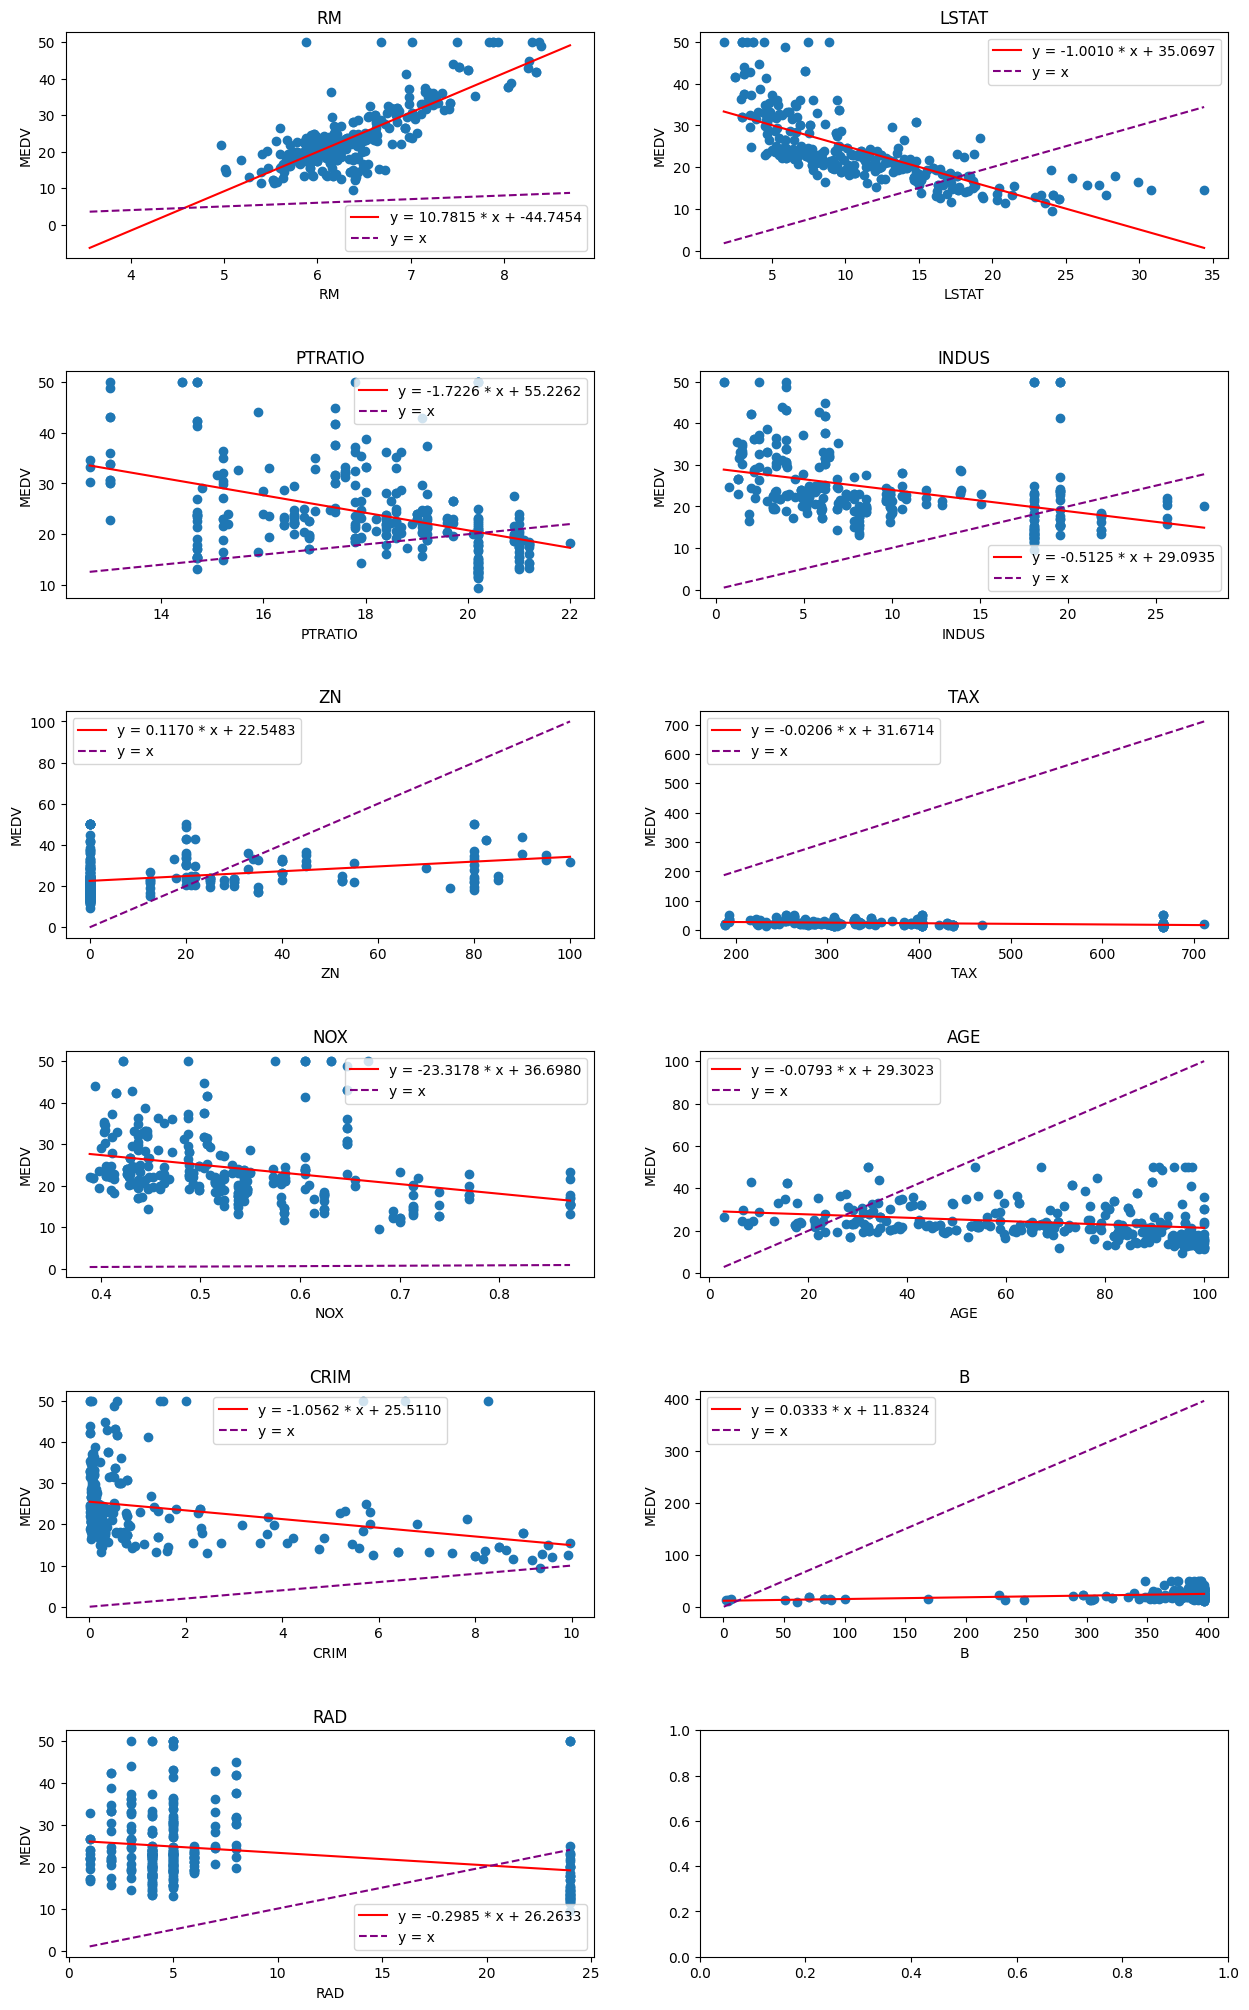

In [281]:
tc, designated_features = Utils.get_designated_cols(df, 'MEDV', threshold=0)

fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(15, 25))
fig.subplots_adjust(hspace=0.5)
for ax, feature in zip(axs.flatten(), designated_features):
    run_linear_regression(df, feature, ax, tc[feature])

`RM` with the highest correlation has a relatively good R-squared score but not very high RMSE, and it also has the second-highest R-squared score, likely plays a crucial role in predicting the target variable and it suggests that this feature is influential in explaining the variance in the target variable, but there might be other factors contributing as well.

`LSTAT` with a high R-squared score and low RMSE, despite having most negative correlation, is valuable for predictive modeling. It indicates that the feature contributes significantly to explaining the variance in the target variable and yields accurate predictions, underscoring the importance of considering multiple aspects of feature importance beyond correlation coefficients.

`RAD` as the feature that has smallest absolute correlation, with a very high RMSE score and a very low R-squared score suggests that although the feature doesn't have a strong linear relationship with the target variable, the model's predictions based on this feature are far off from the actual values, resulting in poor model fit and the model's predictions based on this feature are inaccurate..

# Ploynomial Regression

To extend the simple linear regression to polynomial regression, we can model the relationship between the independent variable $x$ and the dependent variable $y$ as a polynomial function of degree $n$:

$$f(x) = \beta_0 + \beta_1x + \beta_2x^2 + \ldots + \beta_nx^n$$

The steps to find the parameters $\beta_i$ are similar to those in simple linear regression. We again minimize the RSS function by taking the derivatives with respect to each parameter and setting them to 0.

- Step 1: Compute the RSS function for polynomial regression:

$$ RSS = \Sigma (y_i - (\hat{\beta_0} + \hat{\beta_1}x_i + \hat{\beta_2}x_i^2 + \ldots + \hat{\beta_n}x_i^n))^2 $$

- Step 2: Compute the derivatives of the RSS function with respect to each parameter $\beta_i$ and set them to 0 to find the desired parameters.

$$ \frac{\partial RSS}{\partial \beta_i} = 0, \text{ for } i = 0, 1, 2, \ldots, n$$

Solving these equations will give us the optimal values of $\beta_i$ for the polynomial regression model. The specific form of the equations will depend on the degree of the polynomial and the number of parameters.

The general form for finding the coefficients for polynomial regression can be represented as:

$$ \beta = (X^T X)^{-1} X^T y $$

where:
- $X$ is the design matrix with columns $x^0, x^1, x^2, ..., x^n$
- $x^i$ represents the feature vector of $x$ raised to the power of $i$
- $y$ is the target variable vector
- $\beta$ is the coefficient vector for the polynomial regression

By solving for $\beta$ using the above formula, we can obtain the coefficients for the polynomial regression model.

In [282]:
def polynomial_regression(x, y, degree):
  pass
  #TO DO

## Computing the Derivative

As we saw, the cost function is the sum over the data points of the squared difference between an observed output and a predicted output.

Since the derivative of a sum is the sum of the derivatives, we can compute the derivative for a single data point and then sum over data points. We can write the squared difference between the observed output and predicted output for a single point as follows:

$$
(output  - (const* w _{0} + [feature_1] * w_{1} + ...+ [feature_n] * w_{n}  ))^2
$$

With n feautures and a const , So the derivative will be :


$$
2 * (output  - (const* w _{0} + [feature_1] * w_{1} + ...+ [feature_n] * w_{n}  ))
$$

The term inside the paranethesis is just the error (difference between prediction and output). So we can re-write this as:

$$2 * error*[feature_i] $$


That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself. In the case of the constant then this is just twice the sum of the errors!

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors.


With this in mind, complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).


In [283]:
def feature_derivative(errors, feature):
  #TO DO
  pass

## Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of increase and therefore the negative gradient is the direction of decrease and we're trying to minimize a cost function.


The amount by which we move in the negative gradient direction is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. We define this by requiring that the magnitude (length) of the gradient vector to be smaller than a fixed 'tolerance'.


With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent we update the weight for each feature befofe computing our stopping criteria.

In [284]:
# Utility functions for multiple regression

def normalize_features(chosen_features, data_frame):
    for feature in chosen_features:
        data_frame[feature] = (data_frame[feature] - data_frame[feature].mean()) / data_frame[feature].std()
    return data_frame

def predict_output(feature_matrix, weights, bias):
    #TO DO FOR POLYNOMIAL REGRESSION PREDICTION
    return None



## Polynomial Regression Using Gradient Descent

Polynomial regression using gradient descent involves finding the optimal parameters for a polynomial model by iteratively updating them based on the gradient of a loss function, typically the Mean Squared Error (MSE). The steps involved are as follows:

- **Step 1: Define the polynomial model**
The polynomial model has the form:
$$f(x) = \beta_0 + \beta_1x + \beta_2x^2 + \ldots + \beta_nx^n$$

- **Step 2: Define the loss function**
The loss function, such as Mean Squared Error (MSE), measures the error between the actual target values and the predicted values by the model.

- **Step 3: Initialize the coefficients**
Start with initial guesses for the coefficients $\beta_0, \beta_1, \ldots, \beta_n$

- **Step 4: Update the coefficients using Gradient Descent**
Iteratively update the coefficients to minimize the loss function. This is done by computing the gradient of the loss function with respect to each coefficient and making small adjustments in the opposite direction of the gradient.

- **Step 5: Repeat until convergence**
Continue updating the coefficients iteratively until the algorithm converges to the optimal values.

- **Step 6: Use the learned coefficients for prediction**
Once the coefficients converge, they can be used in the polynomial function to make predictions on new data points.

Overall, polynomial regression using gradient descent is an iterative optimization process that aims to find the best-fitting polynomial curve to the data points by minimizing the prediction errors. The learning rate and the number of iterations are key hyperparameters to tune for efficient convergence and accurate modeling.



In [285]:
def polynomial_regression_gradient_descent(feature_matrix, outputs, initial_weights,bias, step_size, tolerance):
    weights = np.array(initial_weights)

    # while True:
        # Compute predictions using polynomial function and errors
        #TO DO

        # Compute derivatives for all weights
        #TO DO

        # Update weights and bias
        #TO DO

        # Check convergence
        #TO DO

    # return weights, bias

In [286]:

def run_polynomial_regression(chosen_feature_matrix, target_matrix, keywords):
    initial_weights = keywords['initial_weights']
    step_size = keywords['step_size']
    tolerance = keywords['tolerance']
    bias = keywords['bias']
    weights = np.array(initial_weights)
    weights, bias = polynomial_regression_gradient_descent(chosen_feature_matrix, target_matrix, weights, bias, step_size, tolerance)

    return weights, bias

def get_weights_and_bias(chosen_features):

    keywords = {
        'initial_weights': np.array([.5]*len(chosen_features)),
        'step_size': 1.e-4,
        'tolerance': 1.e-10,
        'bias': 0
    }

    # TO DO

    # return chosen_feature_matrix, train_weights, bias

# Classification using K-Nearest-Neighbors and Decision Tree

### 21. Pruning, Pros and Cons

Pruning in decision trees refers to the process of reducing the size of the tree by removing parts of it that are not necessary or are redundant. The goal of pruning is to improve the tree's generalization ability, making it more robust and less likely to overfit the training data.

There are generally two types of pruning techniques:

1. **Pre-pruning**: This involves stopping the tree-building process early, before it becomes too complex and starts to overfit the training data. Pre-pruning methods include setting a maximum depth for the tree, limiting the minimum number of samples required to split a node, or requiring a minimum improvement in impurity to perform a split.

2. **Post-pruning**: Also known as "cost-complexity pruning" or "backfitting", post-pruning involves building the full tree and then removing parts of it that are deemed unnecessary. This is typically done by evaluating the impact of removing each subtree on a validation set and selecting the subtree that results in the best performance.

Pros of pruning:

1. **Improves Generalization**: Pruning helps prevent overfitting by simplifying the tree and removing unnecessary branches, which can improve its ability to generalize to unseen data.

2. **Reduces Complexity**: Pruned trees are often simpler and easier to interpret than unpruned trees, making them more understandable for humans.

3. **Computational Efficiency**: By reducing the size of the tree, pruning can lead to faster prediction times and lower memory requirements.

Cons of pruning:

1. **Loss of Information**: Pruning can potentially remove useful information from the tree, leading to a decrease in predictive accuracy, especially if done excessively.

2. **Complexity of Tuning**: Determining the optimal pruning parameters or strategy can be challenging and may require careful tuning and validation.

3. **Risk of Underfitting**: If pruning is too aggressive, it can lead to underfitting, where the tree is too simplistic and fails to capture important patterns in the data.


### 22. Decision Trees Advantages Over Other Models

Decision trees have several advantages over other models in certain cases:

1. **Handling Non-linear Relationships**: When we have a non-linear relationships, Decision trees can be used to caputre without the need for feature engineering or transformation.

3. **No Assumptions about Data Distribution**: When we don't have enough information about the distribution and outliers of our data, Decision trees can be used as they do not make assumptions about the distribution of the data and outliers, unlike parametric models such as linear regression.


1. **Interpretability**: Decision trees are highly interpretable and easy to understand, making them ideal for tasks where interpretability is crucial, such as in medical diagnosis or credit scoring.

5. **Mixed Data Types**: Decision trees can handle both numerical and categorical data without the need for one-hot encoding or other preprocessing techniques.

6. **Scalability**: Decision trees are relatively fast to train and can handle large datasets with many features.

### 23. Main Difference Between KNN and Other Classifications

The main difference between KNN classification and other classification algorithms like Neural Networks or Logistic Regression lies in their training methods:

   - KNN: KNN is a **lazy learning algorithm**, meaning it doesn't explicitly train a model during the training phase. Instead, it memorizes the entire training dataset. During prediction, it calculates the distances between the query instance and all training instances to determine the k nearest neighbors and then assigns the majority class among them as the prediction.

   - Other classifiers: Most other classifiers, including Neural Networks and Logistic Regression, are trained using optimization algorithms like gradient descent or maximum likelihood estimation. They iteratively update model parameters (weights) based on the training data to minimize a loss function.

In overall, the key difference is that KNN doesn't train a model during the training phase but instead stores all training instances for later use during prediction, while other classifiers learn explicit models during training using optimization techniques.

### 24. One Nearest Neighbor, Pros and Cons

One nearest neighbor algorithm, often referred to as 1-NN or 1-Nearest Neighbor, is a simple instance-based learning algorithm used for classification and regression tasks.

**Pros:**

1. **Simple Concept**: 1-NN is easy to understand and implement. It relies on the intuitive idea of classifying a new instance based on the class of its nearest neighbor in the training data.

2. **No Model Training**: 1-NN does not require a separate training phase. Instead, it memorizes the entire training dataset, making it computationally efficient during training.

3. **Adapts to Data Distribution**: Since 1-NN directly uses the training data for classification, it can adapt to complex and non-linear data distributions without making strong assumptions about the underlying data.

4. **Non-parametric**: 1-NN is a non-parametric algorithm, meaning it doesn't make explicit assumptions about the functional form of the decision boundary. This flexibility allows it to capture complex decision boundaries.

**Cons:**

1. **High Prediction Time**: Classifying a new instance with 1-NN involves computing the distance between the query instance and all training instances, which can be computationally expensive, especially for large datasets.

2. **Sensitivity to Noise and Outliers**: 1-NN is sensitive to noisy or irrelevant features in the dataset, as it directly compares the query instance to its nearest neighbor without considering feature importance.

3. **Storage Requirements**: 1-NN requires storing the entire training dataset in memory, which can be memory-intensive for large datasets with many instances or high-dimensional feature spaces.

4. **Vulnerable to Overfitting**: 1-NN can suffer from overfitting, especially in noisy datasets or when using a small value of k (e.g., k=1). In such cases, the model may memorize noise in the training data, leading to poor generalization performance on unseen data.

5. **Choice of Distance Metric**: The performance of 1-NN can be sensitive to the choice of distance metric used to compute the similarity between instances. Choosing an appropriate distance metric is crucial for achieving good classification accuracy.

### 25. Other Distance Measures in KNN

1. **Euclidean Distance**: This is the most commonly used distance measure. The formula is:

    $$ d(x, y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2} $$

    where `x` and `y` are two vectors of length `n`.

2. **Manhattan Distance**: Also known as City Block Distance. This is useful when the difference in each dimension matters equally. The formula is:

    $$ d(x, y) = \sum_{i=1}^{n} |x_i - y_i| $$

3. **Minkowski Distance**: This is a generalized metric form of Euclidean Distance and Manhattan Distance. The formula is:

    $$ d(x, y) = \left(\sum_{i=1}^{n} |x_i - y_i|^p\right)^{1/p} $$

    where `p` is the power parameter. When `p=2`, it becomes the Euclidean Distance. When `p=1`, it becomes the Manhattan Distance.

4. **Hamming Distance**: This is used for categorical variables. If the value (i.e., the category) of the variable differs between the two data points, then the distance is 1, otherwise it is 0. Then all these distances are summed up.

5. **Cosine Similarity**: This measures the cosine of the angle between two vectors. This is particularly useful when dealing with high dimensional data, or when the magnitude of the vectors does not matter much.

    $$ \text{cosine similarity}(x, y) = \frac{x \cdot y}{||x||_2 \cdot ||y||_2} $$

    where `x` and `y` are two vectors, `x · y` is the dot product, and `||x||_2` is the Euclidean length of the vector.

### Implimentation

We make a `Classifier` class and make instances of it for different models in the next parts.

In [297]:
class Classifier():    
    def __init__(self, classifier, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.classifier = classifier
    
    def fit(self):
        self.classifier.fit(self.X_train, self.y_train)

    def get_preds(self, X_test):
        return self.classifier.predict(X_test)
    
    def calc_accuracy(self, y_test, y_pred):
        return accuracy_score(y_test, y_pred)

    def grid_search(self, X_test, param_grid):
        grid = GridSearchCV(self.classifier, param_grid, scoring='neg_mean_squared_error', cv=5)
        grid.fit(self.X_train, self.y_train)
        best_params = grid.best_params_
        best_model = grid.best_estimator_
        best_y_pred = best_model.predict(X_test)
        return best_params, best_model, best_y_pred
    
    def random_search(self, X_test, param_grid):
        grid = RandomizedSearchCV(self.classifier, param_distributions=param_grid, n_iter=15, scoring='accuracy', random_state=42)
        grid.fit(self.X_train, self.y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
        best_y_pred = best_model.predict(X_test)
        return best_params, best_model, best_y_pred

    def normal_run(self, X_test, y_test):
        y_pred_dt = self.get_preds(X_test)
        accuracy = self.calc_accuracy(y_test, y_pred_dt)

        print("Accuracy:", accuracy)

### 26

In [288]:
top_threshold = df['MEDV'].quantile(0.8)
bottom_threshold = df['MEDV'].quantile(0.2)
df['category'] = 0
df.loc[df['MEDV'] >= top_threshold, 'category'] = 1
df.loc[df['MEDV'] <= bottom_threshold, 'category'] = 2
cat_df = df.drop(columns=['MEDV'])

In [289]:
X = cat_df.drop(columns=['category'])
y = cat_df['category']
X_train, X_test, y_train, y_test = Utils.get_train_test(X, y, test_size=0.2)

## KNN Model

### Selecting Hyperparameters with test

In [298]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan', algorithm='auto')
KNN = Classifier(knn_classifier, X_train, y_train)
KNN.normal_run(X_test, y_test)

Accuracy: 0.8431372549019608


### Selecting Hyperparameters with Grid Search CV

In [291]:
knn_param_grid = {
    'n_neighbors': range(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto']
}
best_knn_params, best_knn_model, best_knn_y_pred = KNN.grid_search(X_test, knn_param_grid)
print("Best hyperparameters:", best_knn_params)
accuracy = KNN.calc_accuracy(y_test, best_knn_y_pred)

print("Accuracy:", accuracy)


Best hyperparameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Accuracy: 0.8333333333333334


## Decision Tree Model

### Selecting Hyperparameters with test

In [320]:
dt_classifier = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)
DT = Classifier(dt_classifier, X_train, y_train)
DT.normal_run(X_test, y_test)

Accuracy: 0.8137254901960784


### Selecting Hyperparameters with Grid Search CV

In [314]:
dt_param_grid = {
    'max_depth': range(4, 10),
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(4, 10),
    'max_features': [7, 9, 11, 13]
}
best_dt_params, best_dt_model, best_dt_y_pred = DT.grid_search(X_test, dt_param_grid)
print("Best hyperparameters:", best_dt_params)
accuracy = DT.calc_accuracy(y_test, best_dt_y_pred)

print("Accuracy:", accuracy)

Best hyperparameters: {'max_depth': 8, 'max_features': 9, 'min_samples_leaf': 9, 'min_samples_split': 2}
Accuracy: 0.8627450980392157


### 27. GridSearchCV

GridSearchCV is an algorithm for hyperparameter tuning in machine learning. It works by exhaustively searching through a specified grid of hyperparameters for a given model to find the combination that yields the best performance based on a scoring metric.

 The algorithm works as:

1. Define a grid of hyperparameters and their corresponding values to search over.
2. Split the training dataset into multiple folds and use cross-validation to evaluate the model's performance for each combination of hyperparameters.
3. Fit the model on the training data for each combination of hyperparameters and evaluate its performance on the validation data.
4. Select the combination of hyperparameters that yields the best performance based on the specified scoring metric.
5. Fit the selected best model on the entire training dataset and evaluate its performance on a separate test dataset, if provided.

While GridSearchCV is a powerful tool for hyperparameter tuning, it may not always result in the best answer due to factors such as grid size, scoring metric choice, and model complexity. Careful consideration of these factors and combining GridSearchCV with other techniques can enhance its effectiveness.

- ##### Compare:
    - **KNN**: We can see that our own hyperparameters for model was slightly better than the GridSearchCV hyperparameters as it has 1% more accuracy.

    - **Decision Tree**: We can see that GridSearchCV hyperparameters for model was slightly better than the our own hyperparameters as it has 5% more accuracy.


### 28. Plot Tree

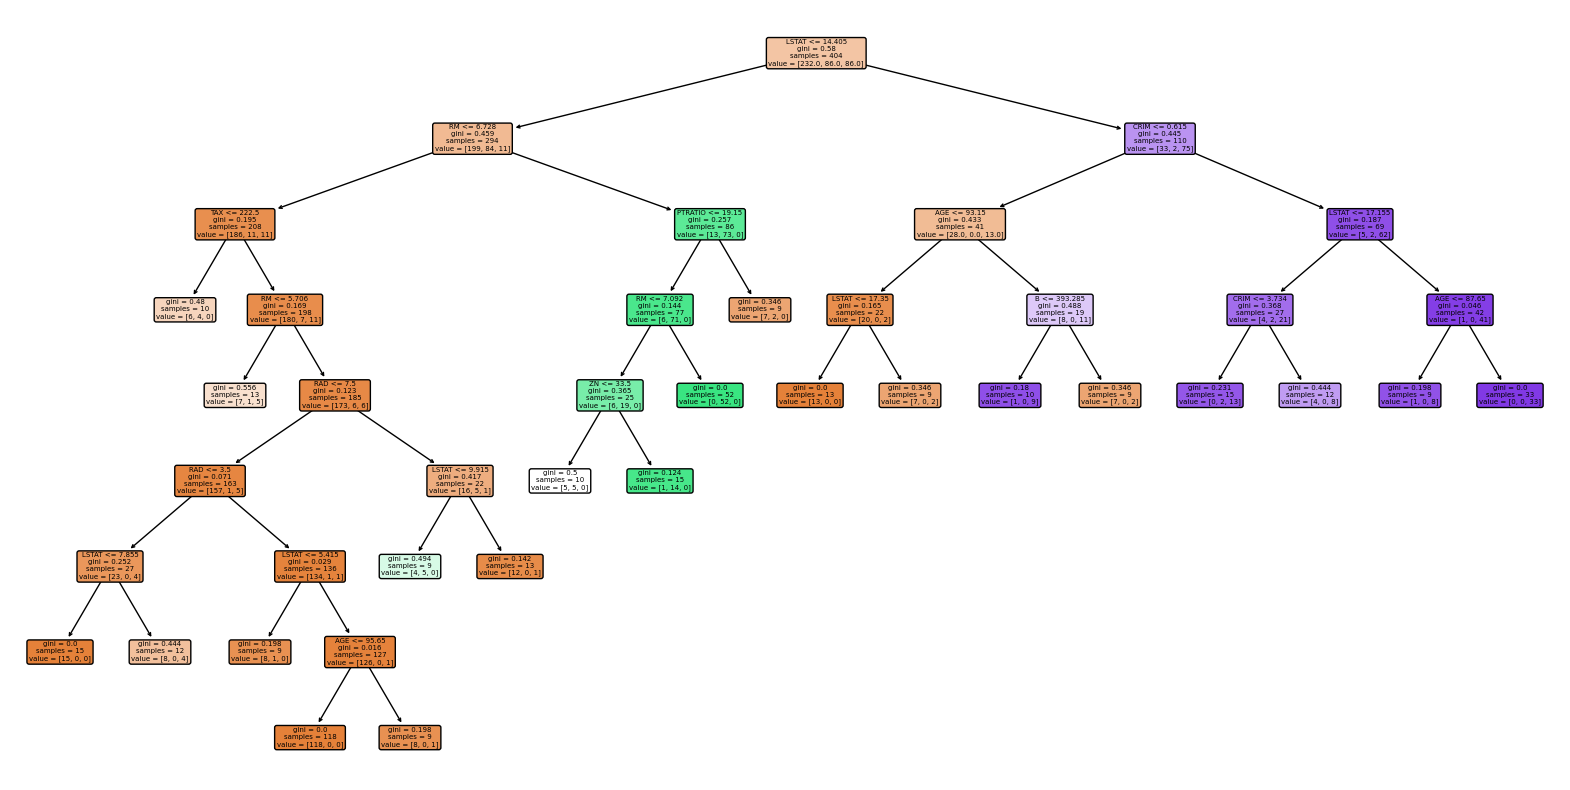

In [315]:
plt.figure(figsize=(20, 10))
plot_tree(best_dt_model, feature_names=list(X.columns), filled=True, rounded=True)
plt.show()

### 29. Underfitting and Overfitting

- **Underfitting**:
   - Underfitting occurs when the model is too simple to capture the underlying patterns in the data.
   - It results in poor performance on both the training and test datasets.
   - Signs of underfitting include high training error and high test error.
   - Underfit models are unable to generalize well to unseen data.

- **Overfitting**:
   - Overfitting occurs when the model is too complex and captures noise or irrelevant patterns in the training data.
   - It results in low training error but high test error, indicating poor generalization to unseen data.
   - Signs of overfitting include low training error and high test error.
   - Overfit models memorize the training data and fail to generalize to new examples.

We can conclude that these haven't occurred in our tests, based on the accuracies we received.

# Ensemble Learning

### 30. Ensemble Methods: Usage and Growth 

There are some reasons why we use them and why they're becoming more important:

1. **Improved Accuracy**: Ensemble methods often result in a higher accuracy than individual models. They reduce both bias and variance in the data by aggregating the predictions of multiple models.

2. **Robustness**: They are more robust to noise and outliers. By leveraging the power of multiple models, they can better handle the complexities and irregularities in the data.

3. **Reduced Overfitting**: Ensemble methods, especially bagging and random forests, help to reduce overfitting by introducing randomness into the model building process.

4. **Handling High Dimensionality**: They can handle high dimensional spaces as well as large amounts of training data more effectively than single models.

5. **Model Diversity**: Ensemble methods introduce diversity into the model building process by combining models that are built using different algorithms or configurations. This diversity often leads to a more robust and accurate combined model.

In today's data-driven world, the demand for accurate and robust predictive models is higher than ever. As data becomes more complex and varied, ensemble methods are becoming more important because they can effectively handle this complexity and deliver superior results. They are widely used in various fields such as healthcare, finance, and autonomous driving, where high prediction accuracy is crucial.

### 31. Boosting and Bagging

**Bagging:**
- Bagging works by creating multiple subsets of the original dataset, with replacement (bootstrap), and then training a separate classifier on each subset.
- The final prediction is made by averaging the predictions (for regression) or taking a majority vote (for classification) from all classifiers.
- Bagging helps to reduce variance and prevent overfitting. It works well when the models are complex and have high variance, such as decision trees.
- An example of a bagging algorithm is the Random Forest.

**Boosting:**
- Boosting works by training classifiers sequentially, where each new classifier is trained to correct the errors made by the previous classifiers.
- Each classifier assigns higher weights to the instances that were misclassified by the previous classifiers, forcing the new classifier to focus more on the difficult instances.
- Boosting helps to reduce bias and variance, and tends to be more sensitive to noisy data and outliers than bagging.
- Examples of boosting algorithms include AdaBoost, Gradient Boosting, and XGBoost.

**Differences between Bagging and Boosting:**
- **Model Training:** Bagging trains models independently in parallel, while Boosting trains models sequentially.
- **Data Sampling:** Bagging uses bootstrap sampling to generate subsets of the original dataset for each model, while Boosting reweights the data based on the errors of the previous model.
- **Final Prediction:** Bagging uses voting for classification or averaging for regression to combine predictions, while Boosting uses a weighted vote.
- **Error Reduction:** Bagging aims to decrease model variance, not bias, and is useful with high variance, low bias models (complex models). Boosting can reduce both bias and variance, and is useful with high bias, low variance models (weak learners).
- **Sensitivity to Noisy Data and Outliers:** Bagging is less sensitive to outliers and noisy data than Boosting.

## Random Forest model

### 32. How It Works

Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. The steps are:

1. **Bootstrap Data**: Random subsets of the original data are created using a process called bootstrapping.
2. **Build Decision Trees**: A decision tree is built for each bootstrap sample. The best split at each node is found from a random subset of features, adding randomness to the tree building process.
3. **Aggregate Predictions**: For a new data point, each tree in the forest gives its own prediction and the final model prediction is made by taking the majority vote (for classification) or averaging the predictions (for regression).

The randomness injected into the building of the trees helps to increase the diversity among the trees and reduce overfitting, making Random Forest a robust and versatile model. It's widely used in various fields due to its simplicity and the fact that it can be used for both classification and regression tasks.

### 33. Bootstrapping in Radnom Forest Model

Bootstrapping in Random Forest model is the method of generating subsets of the original dataset. It's done by randomly sampling with replacement, meaning some data points may appear more than once in a subset, and some may not appear at all.

This process is crucial for the functioning of a Random Forest model for two main reasons:

1. **Diversity**: By creating multiple subsets of the original data, we ensure that each decision tree in the forest is trained on a slightly different set of data. This diversity leads to a collection of trees that are uncorrelated or weakly correlated, making the ensemble model more robust and less prone to overfitting.

2. **Out-of-Bag Error Estimation**: The data points not included in a bootstrap sample serve as a validation set, known as out-of-bag (OOB) data. This allows for an unbiased error estimation of the model performance during the training phase, without the need for a separate validation set.

In terms of how it affects the answers, bootstrapping contributes to the robustness and generalization ability of the Random Forest model. Since each tree is trained on a different subset of data, the model is able to capture a wider range of patterns and correlations in the data, leading to more accurate and reliable predictions. 

It also helps in reducing the variance of the model without increasing the bias, which is a common problem in single decision trees.

### 34. Number of Trees in Random Forest Model

The number of trees does affect the performance of the model:

1. **Accuracy**: As the number of trees increases, the model's accuracy may improve as it has more opportunities to learn from different subsets of data. However, after a certain point, the improvement in accuracy tends to plateau, meaning adding more trees won't lead to any significant improvement.

2. **Overfitting**: Random Forest models are less prone to overfitting with an increase in the number of trees, unlike some other models. This is because each tree in the forest is trained independently of the others, and the final prediction is an average of the predictions from all trees, which tends to reduce overfitting.

3. **Computational Cost**: More trees require more computational resources and more time to train and predict. Therefore, there's a trade-off between the computational cost and the model performance.

In practice, a common strategy is to start with a reasonable number like `100 trees` and then fine-tune this number based on the model performance and the computational resources available.

### 35. When To Use and When Not

**When not to use Random Forest:**
1. **Interpretability is Important**: If we need a model that is easy to interpret and explain, Random Forest may not be the best choice. Individual decision trees are generally easy to interpret, but a forest of them is not.

2. **Linear Relationships**: If the relationships in the data are linear, a linear model will likely perform better. Random Forest can approximate these relationships but it may not be as efficient or accurate.

3. **High-Dimensional Sparse Data**: In cases of high-dimensional sparse data, such as text data, other models like Support Vector Machines (SVM) or Naive Bayes might be more suitable.

4. **Real-Time Predictions**: Random Forest can be slow in generating predictions as it needs to run the input data through a number of trees. So, if we need real-time predictions, a simpler or more computationally efficient model might be a better choice.

**When to use Random Forest:**
1. **Non-Linear Relationships**: Random Forest is great when the relationships in your data are non-linear and complex.

2. **Large Datasets**: Random Forest can handle large datasets with many features and high dimensionality effectively.

3. **Robustness to Outliers and Noisy Data**: Random Forest is quite robust to outliers and noisy data as it averages out the impact of such data points.

4. **Feature Importance**: Random Forest provides a good estimate of which features are important in making predictions.

### 36. Varianece in Random Forest

Random Forest helps to **reduce the variance** of the model's predictions. Here are the reasons:

1. **Averaging**: It averages predictions from multiple trees, reducing individual tree errors.
2. **Diversity**: Each tree is trained on different data subsets, adding diversity and reducing overfitting.
3. **Overfitting**: It’s less prone to overfitting than a single decision tree, which inherently reduces variance.

### 37. Hyperparameters

- **n_estimators**: The number of decision trees in the forest.

- **max_depth**: The maximum depth of each decision tree. Controls the complexity of individual trees and helps prevent overfitting.

- **min_samples_split**: The minimum number of samples required to split an internal node. Helps prevent splitting nodes with too few samples, reducing overfitting.

- **min_samples_leaf**: The minimum number of samples required to be at a leaf node. Helps control the size of leaf nodes and prevent overfitting.

- **max_features**: The maximum number of features to consider when looking for the best split. Controls the randomness of each tree and helps prevent overfitting by reducing correlation between trees.

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
RF = Classifier(rf_classifier, X_train, y_train)

best_rf_params, best_rf_model, best_rf_y_pred = RF.grid_search(X_test, rf_param_grid)
print("Best hyperparameters:", best_rf_params)
accuracy = RF.calc_accuracy(y_test, best_rf_y_pred)

print("Accuracy:", accuracy)


Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.8431372549019608


## XGBoost model

### 38. How It Works

XGBoost is a machine learning algorithm that uses the gradient boosting framework. It works by building a series of decision trees in a sequential manner where each new tree is trained to correct the errors made by the previous ones. It incorporates a regularization term in its cost function to prevent overfitting, and it has efficient routines for handling missing values and pruning trees. XGBoost also allows for built-in cross-validation at each iteration of the boosting process, making it a highly flexible, efficient, and robust algorithm for structured or tabular data.

### 39.1. Gradient Boosting, Boosting Tree and Decision Tree

**Gradient Boosting**:

- It is a powerful machine learning technique used for both classification and regression problems. It works on the principle of ensemble learning, which involves training multiple weak learners (typically decision trees) and combining their predictions to make a final prediction.

- Here's how it works:

    1. **Sequential Learning**: Gradient Boosting trains learners in a sequential manner. Each new model is trained to correct the errors made by the previous models.

    2. **Weak Learners**: The individual models are weak learners, typically decision trees, that perform only slightly better than random chance. These weak learners are added sequentially and focus on the errors of the previous model.

    3. **Error Correction**: In each iteration, the algorithm computes the negative gradient (hence the name "Gradient Boosting") of the loss function with respect to the predicted output, and then trains a new weak model to predict this gradient.

    4. **Final Prediction**: The final prediction is a weighted sum of the predictions of all the individual models.

- The key idea behind Gradient Boosting is to add new models to the ensemble sequentially. Each new model gradually minimizes the loss function of the whole system using the Gradient Descent method. This makes Gradient Boosting a robust and efficient technique for a wide range of regression and classification problems.


**Decision Tree Vs. Boosting Tree**:

- A **Decision Tree** is a simple, decision-making diagram. It's a standalone model that makes predictions based on a series of binary splits on the features of the data. However, a decision tree can suffer from problems like overfitting, high variance, and bias error.

- A **Boosting Tree** is part of an ensemble method known as Gradient Boosting. It's not a single tree, but a sequence of trees where each new tree is trained to correct the errors made by the previous ones. Boosting trees start the combining process at the beginning, instead of at the end. They are typically more accurate than a single decision tree because they learn gradually from the mistakes of the ensemble.

In overall, while a decision tree is a single model that makes decisions based on binary splits, a boosting tree is part of an ensemble of trees that work together to make more accurate predictions by learning from each other's mistakes.

### 39.2. Hyperparameters

- n_estimators: The number of boosting rounds or the number of trees in the ensemble. 

- max_depth: The maximum depth of each decision tree in the ensemble. Controls the complexity of individual trees and helps prevent overfitting.

- learning_rate: The step size at which each boosting round contributes to the overall model. A higher learning rate may lead to faster convergence but can also increase the risk of overfitting. Adjusting the learning rate allows for fine-tuning the trade-off between model performance and training time.

In [ ]:
xgb_regressor = XGBClassifier(random_state=42)
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}
XGB = Classifier(xgb_regressor, X_train, y_train)

best_xgb_params, best_xgb_model, best_xgb_y_pred = XGB.grid_search(X_test, xgb_param_grid)
print("Best hyperparameters:", best_xgb_params)
accuracy = XGB.calc_accuracy(y_test, best_xgb_y_pred)

print("Accuracy:", accuracy)


Best hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 150}
Accuracy: 0.8529411764705882


# Support Vector Machine

### 40. Random Search Vs. Grid Search

Grid Search is a suitable choice for this project due to the small and well-defined hyperparameter search space. It works by exhaustively testing all possible combinations of hyperparameters and selecting the set that delivers the best model performance. 

Given that we have sufficient computational resources, this method is both efficient and effective. It allows us to systematically explore the entire hyperparameter space and find the optimal set for our model, thereby improving the model's performance on the task at hand.

## RBF Kernel

In [ ]:
rbf_svc_classifier = SVC(kernel='rbf')
RBF_SVC = Classifier(rbf_svc_classifier, X_train, y_train)
RBF_SVC.fit()
y_pred_rbf_svc = RBF_SVC.get_preds(X_test)
accuracy = RBF_SVC.calc_accuracy(y_test, y_pred_rbf_svc)

print("Accuracy:", accuracy)

Accuracy: 0.696078431372549


In [ ]:
rs_param_grid = {
    'C': uniform(loc=0, scale=20),
    'gamma': uniform(loc=0, scale=0.4)
}

RS = Classifier(rbf_svc_classifier, {}, X_train, y_train)

best_rs_params, best_rs_model, best_rs_y_pred = RS.random_search(X_test, rs_param_grid)
print("Best hyperparameters:", best_rs_params)
accuracy = RS.calc_accuracy(y_test, best_rs_y_pred)
print("Accuracy:", accuracy)

Best hyperparameters: {'C': 11.84829137724085, 'gamma': 0.01858016508799909}
Accuracy: 0.8529411764705882


In [ ]:
rs_param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto']
}
best_rs_params, best_rs_model, best_rs_y_pred = RS.grid_search(X_test, rs_param_grid)
print("Best hyperparameters:", best_rs_params)
accuracy = RS.calc_accuracy(y_test, best_rs_y_pred)
print("Accuracy:", accuracy)

Best hyperparameters: {'C': 1000, 'gamma': 'scale'}
Accuracy: 0.803921568627451


## Linear Kernel

In [ ]:
lsvc_classifier = SVC(kernel='linear')
LSVC = Classifier(lsvc_classifier, X_train, y_train)
LSVC.fit()
y_pred_lsvc = LSVC.get_preds(X_test)
accuracy = LSVC.calc_accuracy(y_test, y_pred_lsvc)

print("Accuracy:", accuracy)

Accuracy: 0.803921568627451


In [ ]:
lsvc_param_grid = {
    'C': uniform(loc=0, scale=20),
    'gamma': uniform(loc=0, scale=0.4)
}

lsvc = Classifier(lsvc_classifier, {}, X_train, y_train)

best_lsvc_params, best_lsvc_model, best_lsvc_y_pred = lsvc.random_search(X_test, lsvc_param_grid)
print("Best hyperparameters:", best_lsvc_params)
accuracy = lsvc.calc_accuracy(y_test, best_lsvc_y_pred)
print("Accuracy:", accuracy)

Best hyperparameters: {'C': 16.648852816008436, 'gamma': 0.08493564427131046}
Accuracy: 0.8137254901960784


In [ ]:
lsvc_param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto']
}
best_lsvc_params, best_lsvc_model, best_lsvc_y_pred = lsvc.grid_search(X_test, lsvc_param_grid)
print("Best hyperparametelsvc:", best_lsvc_params)
accuracy = lsvc.calc_accuracy(y_test, best_lsvc_y_pred)
print("Accuracy:", accuracy)

Best hyperparametelsvc: {'C': 0.1, 'gamma': 'scale'}
Accuracy: 0.7941176470588235


# Scoring

In [ ]:
class Scoring():
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.model = None
        self.y_pred = None

    def set_model(self, model):
        self.model = model
        self.y_pred = self.model.predict(X_test)

    def show_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred)

        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()


    def run_all(self):
        self.show_confusion_matrix()

        accuracy = accuracy_score(self.y_test, self.y_pred)
        print("Accuracy Score:", accuracy)

        report = classification_report(self.y_test, self.y_pred, zero_division=0)
        print(report)

In [ ]:
scoring = Scoring(X_test, y_test)

## KNN Scoring

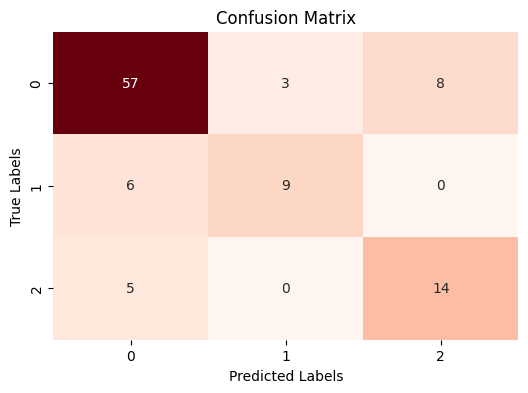

Accuracy Score: 0.7843137254901961
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        68
           1       0.75      0.60      0.67        15
           2       0.64      0.74      0.68        19

    accuracy                           0.78       102
   macro avg       0.74      0.73      0.73       102
weighted avg       0.79      0.78      0.78       102



In [ ]:
scoring.set_model(best_knn_model)
scoring.run_all()

## Decision Tree Scoring

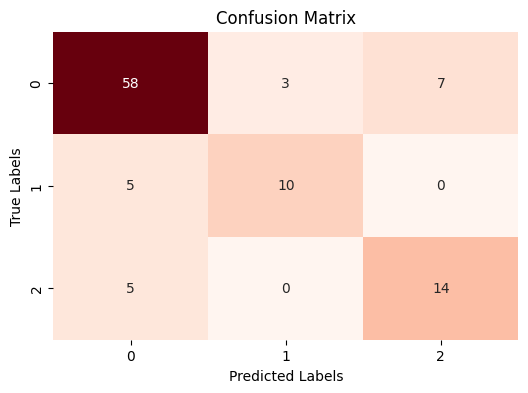

Accuracy Score: 0.803921568627451
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        68
           1       0.77      0.67      0.71        15
           2       0.67      0.74      0.70        19

    accuracy                           0.80       102
   macro avg       0.76      0.75      0.76       102
weighted avg       0.81      0.80      0.80       102



In [ ]:
scoring.set_model(best_dt_model)
scoring.run_all()

## Random Forest Scoring

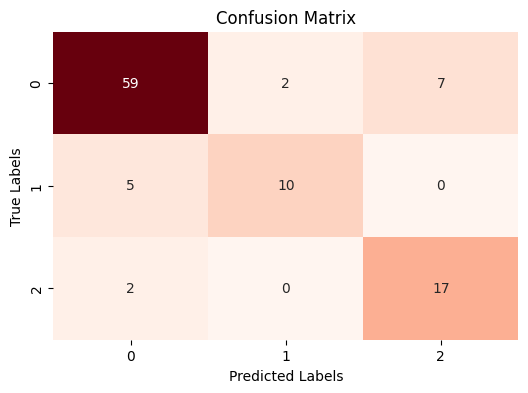

Accuracy Score: 0.8431372549019608
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        68
           1       0.83      0.67      0.74        15
           2       0.71      0.89      0.79        19

    accuracy                           0.84       102
   macro avg       0.81      0.81      0.80       102
weighted avg       0.85      0.84      0.84       102



In [ ]:
scoring.set_model(best_rf_model)
scoring.run_all()

## XGBoost Scoring

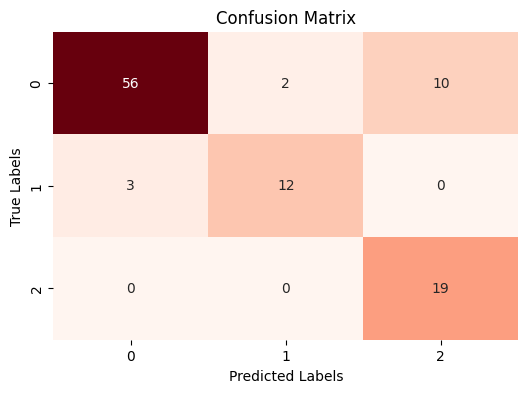

Accuracy Score: 0.8529411764705882
              precision    recall  f1-score   support

           0       0.95      0.82      0.88        68
           1       0.86      0.80      0.83        15
           2       0.66      1.00      0.79        19

    accuracy                           0.85       102
   macro avg       0.82      0.87      0.83       102
weighted avg       0.88      0.85      0.86       102



In [ ]:
scoring.set_model(best_xgb_model)
scoring.run_all()

## Support Vector Machine Scoring

### RBF Kernel

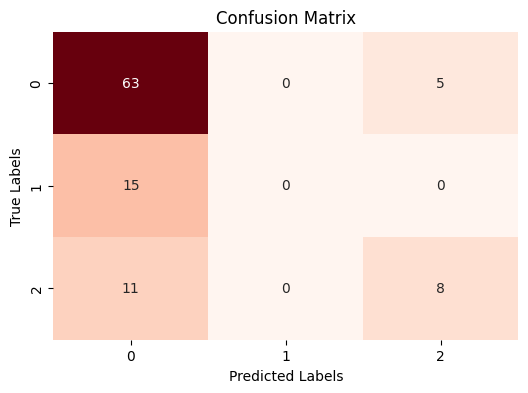

Accuracy Score: 0.696078431372549
              precision    recall  f1-score   support

           0       0.71      0.93      0.80        68
           1       0.00      0.00      0.00        15
           2       0.62      0.42      0.50        19

    accuracy                           0.70       102
   macro avg       0.44      0.45      0.43       102
weighted avg       0.59      0.70      0.63       102



In [ ]:
scoring.set_model(rbf_svc_classifier)
scoring.run_all()

### Linear Kernel

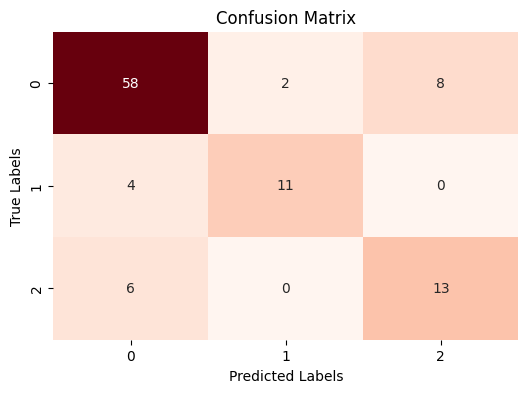

Accuracy Score: 0.803921568627451
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        68
           1       0.85      0.73      0.79        15
           2       0.62      0.68      0.65        19

    accuracy                           0.80       102
   macro avg       0.77      0.76      0.76       102
weighted avg       0.81      0.80      0.81       102



In [ ]:
scoring.set_model(lsvc_classifier)
scoring.run_all()